In [1]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from tqdm import tqdm
import re
from datetime import datetime
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

### load spatial dataset

In [2]:
#load the resulting shapefile using geopandas
zipcode = gpd.read_file('../Data/ZIPCODE/ZIP_CODE_040114.shp')
zipcode.head()

ZIPCODE BLDGZIP   PO_NAME  POPULATION          AREA STATE  COUNTY ST_FIPS  \
0   11436       0   Jamaica     18681.0  2.269930e+07    NY  Queens      36   
1   11213       0  Brooklyn     62426.0  2.963100e+07    NY   Kings      36   
2   11212       0  Brooklyn     83866.0  4.197210e+07    NY   Kings      36   
3   11225       0  Brooklyn     56527.0  2.369863e+07    NY   Kings      36   
4   11218       0  Brooklyn     72280.0  3.686880e+07    NY   Kings      36   

  CTY_FIPS                   URL  SHAPE_AREA  SHAPE_LEN  \
0      081  http://www.usps.com/         0.0        0.0   
1      047  http://www.usps.com/         0.0        0.0   
2      047  http://www.usps.com/         0.0        0.0   
3      047  http://www.usps.com/         0.0        0.0   
4      047  http://www.usps.com/         0.0        0.0   

                                            geometry  
0  POLYGON ((1038098.252 188138.380, 1038141.936 ...  
1  POLYGON ((1001613.713 186926.440, 1002314.243 ...  
2  POLYGON ((1011174.276 183696.338, 1011373.584 ...  
3  POLYGON ((995908.365 183617.613, 996522.848 18...  
4  POLYGON ((991997.113 176307.496, 992042.798 17...

In [3]:
zipcode = zipcode[zipcode.POPULATION > 0]

In [4]:
# zipcode["ZIPCODE"] = zipcode["ZIPCODE"].astype(np.float64)

In [5]:
zipcode.dropna(axis=0,how='any', inplace=True)

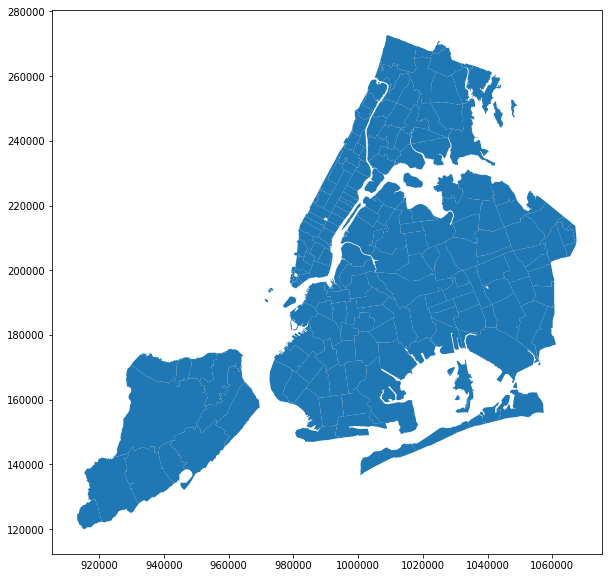

In [6]:
zipcode.plot(figsize=(10,10))

### load disorder dataset

In [7]:
disorderData = pd.read_csv("../ExploreDisorder&Crime/DisorderData.csv")
disorderData.dropna(axis=0,how='any', inplace=True)
disorderData.head()

zipcode        date  year  month  timeinterval  isWeekend  \
0   11228  11/06/2017  2017     11            10          0   
1   10014  11/06/2017  2017     11             0          0   
2   11238  11/06/2017  2017     11            15          0   
3   10306  11/06/2017  2017     11            11          0   
4   11416  11/06/2017  2017     11             0          0   

          disorder_name  disorder_type  
0                Damage              5  
1                Damage              5  
2                Damage              5  
3                Damage              5  
4  Uncivil Use of Space              1

In [8]:
zipcode_disorder_count = disorderData.groupby("zipcode").zipcode.agg('count').to_frame('count').reset_index()

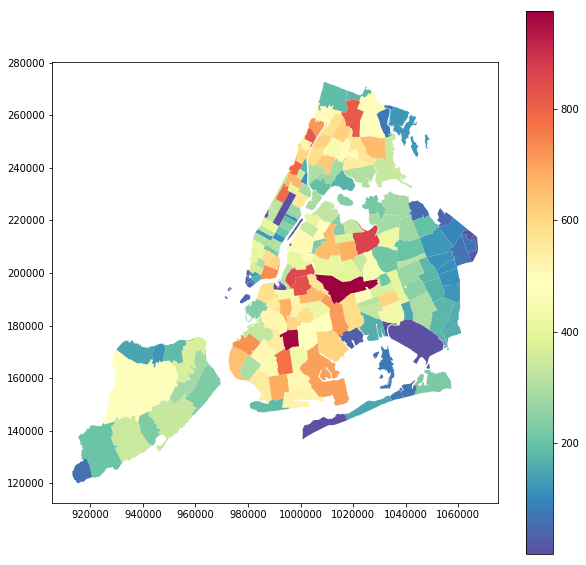

In [9]:
#merge data with the zip code shapes into a new geopandas dataframe
zipcode_disorder_count_geo = zipcode.merge(zipcode_disorder_count,left_on='ZIPCODE',right_on='zipcode',how='left')
zipcode_disorder_count_geo.plot(column='count',colormap='Spectral_r',legend=True,markersize=0.01,figsize=(10,10))

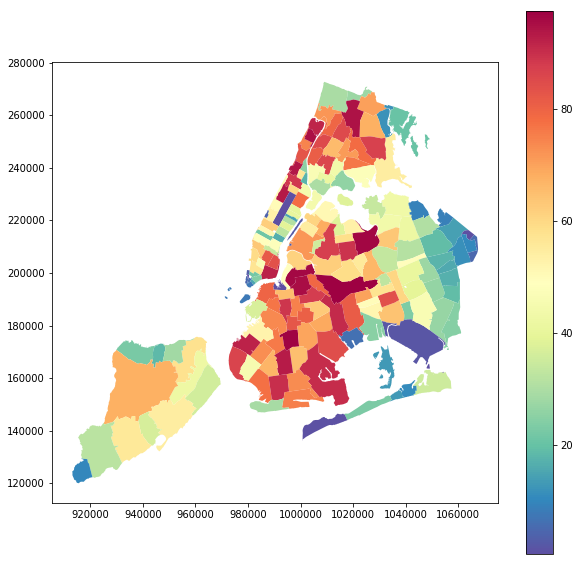

In [10]:
index_ = zipcode_disorder_count_geo["count"].values
zipcode_disorder_count_geo["count_percentile"] = zipcode_disorder_count_geo["count"].apply(lambda x:stats.percentileofscore(index_, x)) 

zipcode_disorder_count_geo.plot(column='count_percentile',colormap='Spectral_r',legend=True,markersize=0.01,figsize=(10,10))

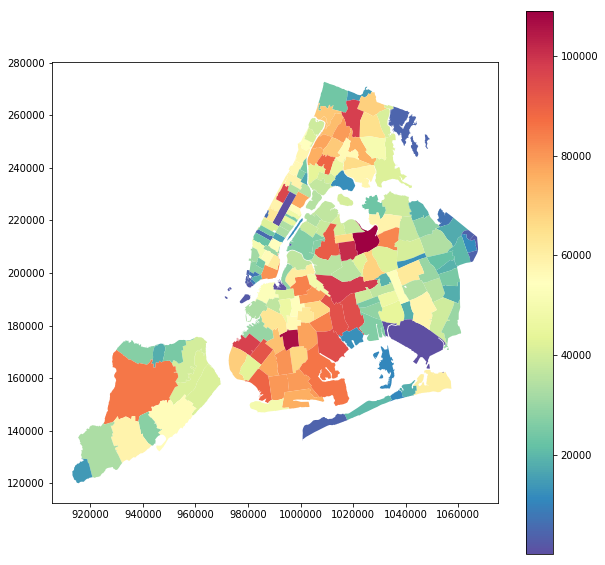

In [11]:
zipcode_disorder_count_geo.plot(column='POPULATION',colormap='Spectral_r',legend=True,markersize=0.01,figsize=(10,10))

In [12]:
index_ = zipcode_disorder_count_geo.POPULATION.values
zipcode_disorder_count_geo["population_percentile"] = zipcode_disorder_count_geo["POPULATION"].apply(lambda x:stats.percentileofscore(index_, x)) 

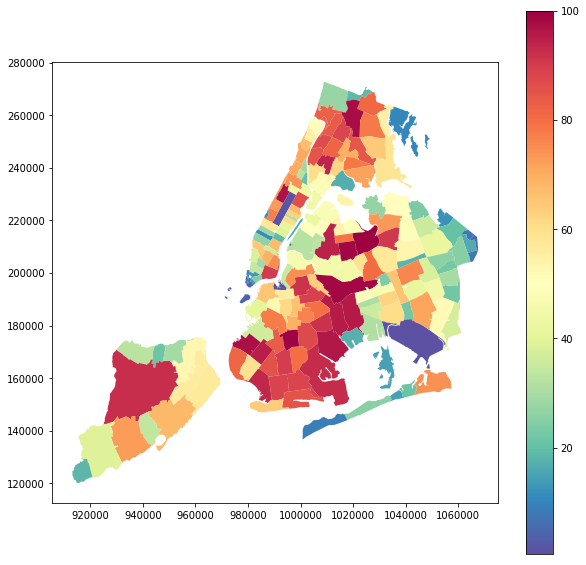

In [13]:
zipcode_disorder_count_geo.plot(column='population_percentile',colormap='Spectral_r',legend=True,markersize=0.01,figsize=(10,10))

In [14]:
zipcode_disorder_count_geo["count_population"] = zipcode_disorder_count_geo["count_percentile"]/zipcode_disorder_count_geo["population_percentile"]

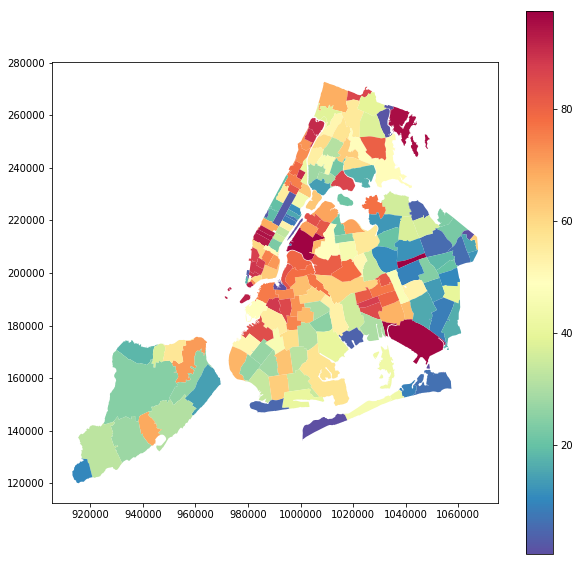

In [15]:
index_ = zipcode_disorder_count_geo.count_population.values
zipcode_disorder_count_geo["count_population_percentile"] = zipcode_disorder_count_geo["count_population"].apply(lambda x:stats.percentileofscore(index_, x)) 
zipcode_disorder_count_geo.plot(column='count_population_percentile',colormap='Spectral_r',legend=True, markersize=0.01,figsize=(10,10))

In [16]:
disorderData.head()

zipcode        date  year  month  timeinterval  isWeekend  \
0   11228  11/06/2017  2017     11            10          0   
1   10014  11/06/2017  2017     11             0          0   
2   11238  11/06/2017  2017     11            15          0   
3   10306  11/06/2017  2017     11            11          0   
4   11416  11/06/2017  2017     11             0          0   

          disorder_name  disorder_type  
0                Damage              5  
1                Damage              5  
2                Damage              5  
3                Damage              5  
4  Uncivil Use of Space              1

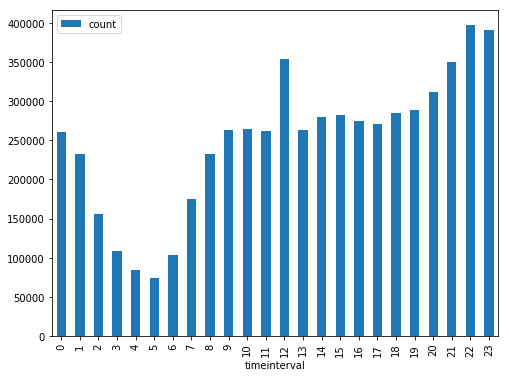

In [17]:
ti_disorder_count = disorderData.groupby(["timeinterval"]).timeinterval.agg('count').to_frame('count').reset_index()
ti_disorder_count.set_index(['timeinterval'],inplace=True)
ti_disorder_count.plot(kind="bar", figsize=(8,6))

In [18]:
disorderData.disorder_name.unique()

array(['Damage', 'Uncivil Use of Space', 'Noise', 'Others',
       'Drug & Alcohol', 'Graffiti', 'Trash', 'Misdemeanor & Violation'],
      dtype=object)

In [19]:
# for type_ in disorderData.disorder_name.unique():
#     ti_disorder_count_ = disorderData[disorderData.disorder_name==type_].groupby(["timeinterval"]).timeinterval.agg('count').to_frame('count').reset_index()
#     ti_disorder_count_.set_index(['timeinterval'],inplace=True)
#     ti_disorder_count_.plot(kind="bar", title=type_,figsize=(8,6))

In [20]:
x_labels = []
for y in range(2015, 2020):
    for m in range(1,13):
        x_labels.append(str(y) + "-" + str(m).zfill(2))
len(x_labels)

60

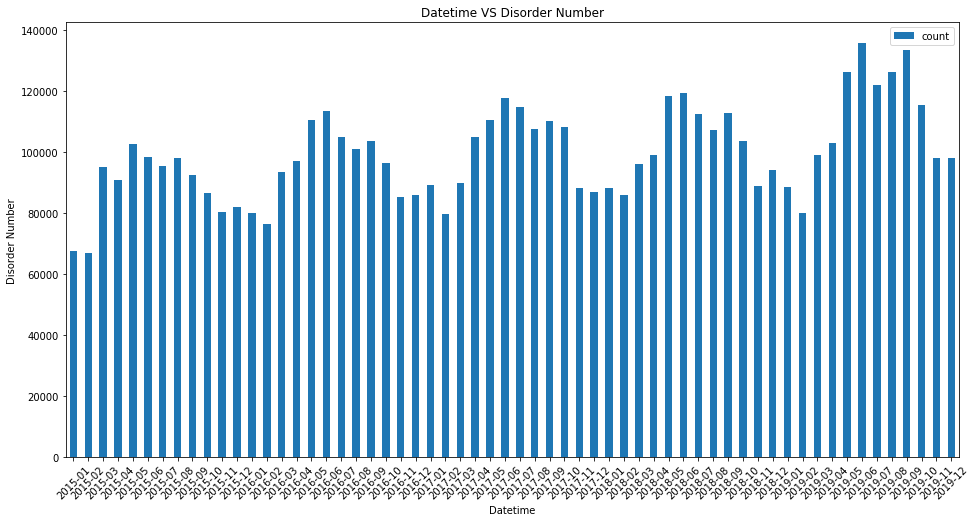

In [21]:
long_term_disorder_count = disorderData.groupby(["year", "month"]).month.agg('count').to_frame('count').reset_index()
ax = long_term_disorder_count[["count"]].plot(kind="bar",figsize=(16,8))

ax.set_xticklabels(x_labels)
plt.title("Datetime VS Disorder Number")
plt.xlabel("Datetime")
plt.ylabel("Disorder Number")
plt.xticks(rotation=45)
plt.show()

In [22]:
disorderData_weekday = disorderData[disorderData.isWeekend==0]
disorderData_weekend = disorderData[disorderData.isWeekend==1]
disorderData_weekday.head()

zipcode        date  year  month  timeinterval  isWeekend  \
0   11228  11/06/2017  2017     11            10          0   
1   10014  11/06/2017  2017     11             0          0   
2   11238  11/06/2017  2017     11            15          0   
3   10306  11/06/2017  2017     11            11          0   
4   11416  11/06/2017  2017     11             0          0   

          disorder_name  disorder_type  
0                Damage              5  
1                Damage              5  
2                Damage              5  
3                Damage              5  
4  Uncivil Use of Space              1

In [23]:
disorderData_weekday_count = disorderData_weekday.groupby("zipcode").zipcode.agg('count').to_frame('count').reset_index()
disorderData_weekend_count = disorderData_weekend.groupby("zipcode").zipcode.agg('count').to_frame('count').reset_index()

In [24]:
zipcode_disorder_count_weekday_geo = zipcode.merge(disorderData_weekday_count,left_on='ZIPCODE',right_on='zipcode',how='left')

In [25]:
zipcode_disorder_count_weekend_geo = zipcode.merge(disorderData_weekend_count,left_on='ZIPCODE',right_on='zipcode',how='left')

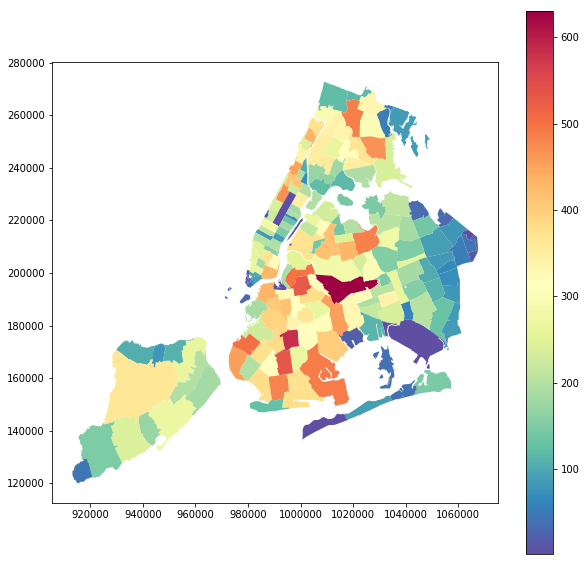

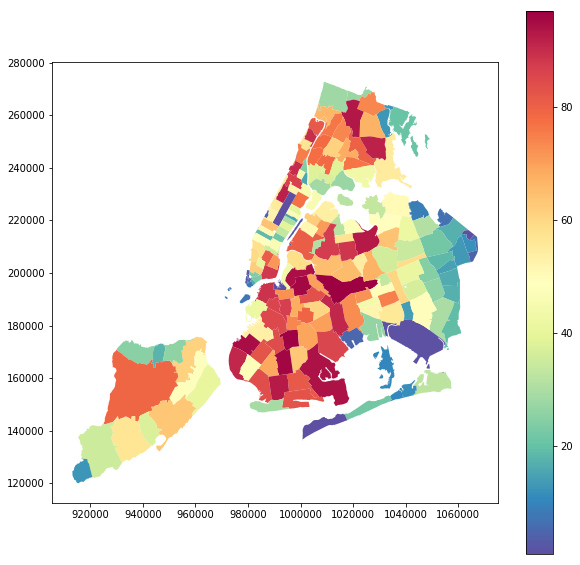

In [26]:
index_ = zipcode_disorder_count_weekday_geo["count"].values
zipcode_disorder_count_weekday_geo["count_percentile"] = zipcode_disorder_count_weekday_geo["count"].apply(lambda x:stats.percentileofscore(index_, x)) 
zipcode_disorder_count_weekday_geo.plot(column='count',colormap='Spectral_r',legend=True, markersize=0.01,figsize=(10,10))
zipcode_disorder_count_weekday_geo.plot(column='count_percentile',colormap='Spectral_r',legend=True, markersize=0.01,figsize=(10,10))

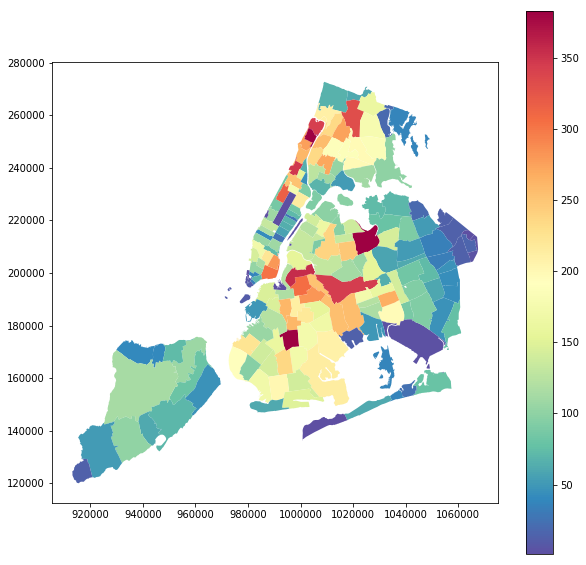

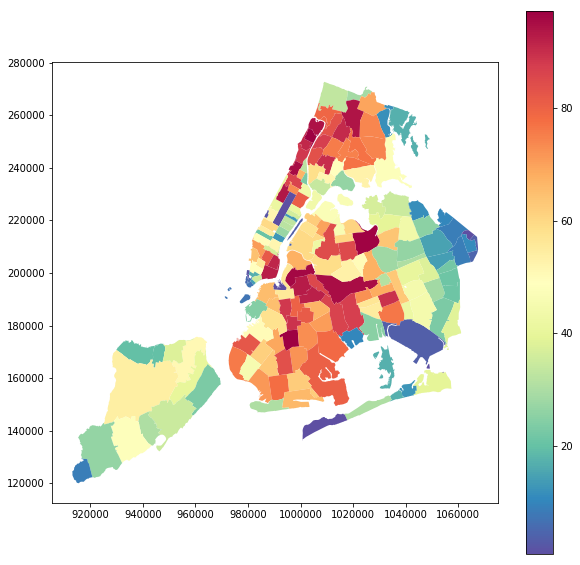

In [27]:
index_ = zipcode_disorder_count_weekend_geo["count"].values
zipcode_disorder_count_weekend_geo["count_percentile"] = zipcode_disorder_count_weekend_geo["count"].apply(lambda x:stats.percentileofscore(index_, x)) 
zipcode_disorder_count_weekend_geo.plot(column='count',colormap='Spectral_r',legend=True, markersize=0.01,figsize=(10,10))
zipcode_disorder_count_weekend_geo.plot(column='count_percentile',colormap='Spectral_r',legend=True, markersize=0.01,figsize=(10,10))

### The distribution of different disorder types with the hour change

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

In [29]:
disorder_timeinterval = np.zeros((8, 24))

In [30]:
for type_ in sorted(disorderData.disorder_type.unique()):
    ti_disorder_count_ = disorderData[disorderData.disorder_type==type_].groupby(["timeinterval"]).timeinterval.agg('count').to_frame('count').reset_index()
    ti_disorder_count_.set_index(['timeinterval'],inplace=True)
    index_ = ti_disorder_count_["count"].values
    type_count_percentile = ti_disorder_count_["count"].apply(lambda x:stats.percentileofscore(index_, x)) 
    disorder_timeinterval[type_-1,:] = type_count_percentile

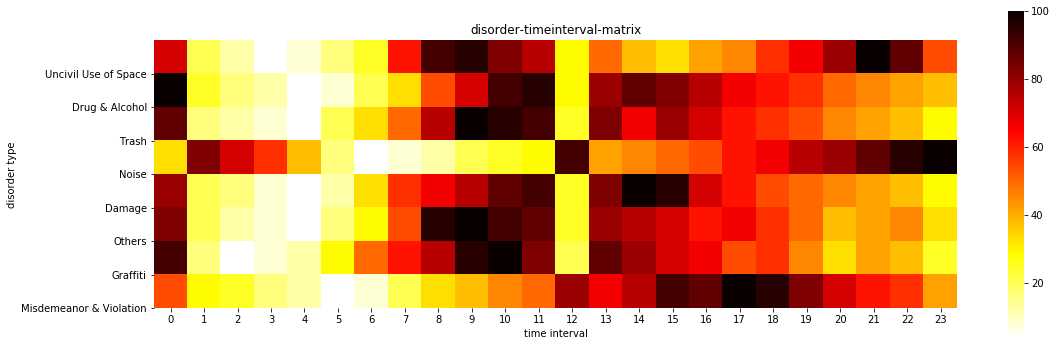

In [31]:
f, ax = plt.subplots(figsize=(18, 6))
sns.heatmap(disorder_timeinterval, cmap="hot_r", square=True)
plt.title("disorder-timeinterval-matrix")
plt.yticks(np.arange(1, 9, 1),["Uncivil Use of Space", "Drug & Alcohol", "Trash", "Noise", "Damage", "Others", "Graffiti", "Misdemeanor & Violation"], rotation=0)
plt.xlabel("time interval")
plt.ylabel("disorder type")
plt.show()

### load crime dataset

In [32]:
crimeData = pd.read_csv("../ExploreDisorder&Crime/CrimeData.csv")
crimeData.head()

zipcode        date  year  month  timeinterval  isWeekend      crime_name  \
0  11213.0  07/23/2016  2016      7             2          1   Violent Crime   
1  10467.0  02/26/2017  2017      2             4          1   Violent Crime   
2  11231.0  08/14/2017  2017      8            21          0  Property Crime   
3  10037.0  09/18/2016  2016      9            23          1  Property Crime   
4  10019.0  03/17/2016  2016      3             0          0  Property Crime   

   crime_type  
0           1  
1           1  
2           2  
3           2  
4           2

In [33]:
zipcode["ZIPCODE"] = zipcode["ZIPCODE"].astype(np.float64)

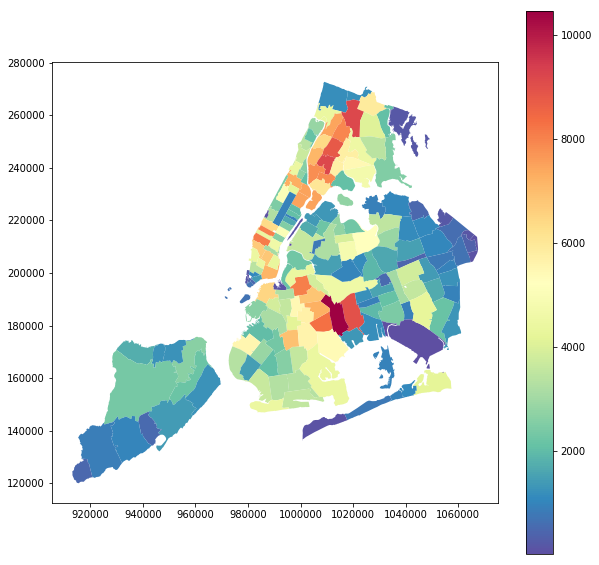

In [34]:
zipcode_crime_count = crimeData.groupby("zipcode").zipcode.agg('count').to_frame('count').reset_index()
zipcode_crime_count_geo = zipcode.merge(zipcode_crime_count,left_on='ZIPCODE',right_on='zipcode',how='left')
zipcode_crime_count_geo.plot(column='count',colormap='Spectral_r',legend=True,markersize=0.01,figsize=(10,10))

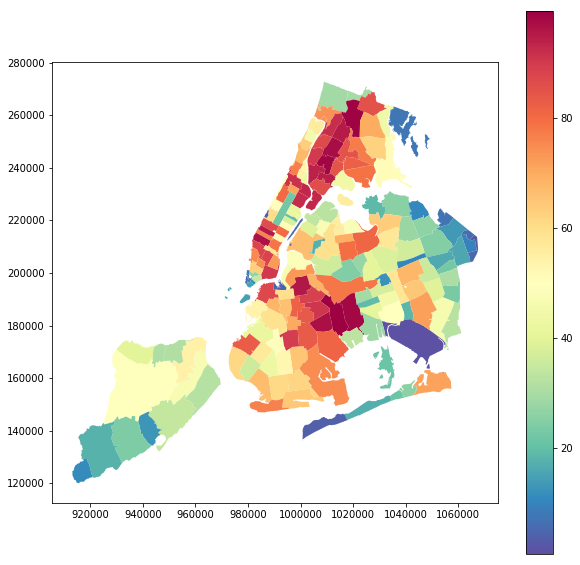

In [35]:
index_ = zipcode_crime_count_geo["count"].values
zipcode_crime_count_geo["count_percentile"] = zipcode_crime_count_geo["count"].apply(lambda x:stats.percentileofscore(index_, x)) 

zipcode_crime_count_geo.plot(column='count_percentile',colormap='Spectral_r',legend=True,markersize=0.01,figsize=(10,10))

In [36]:
index_ = zipcode_crime_count_geo.POPULATION.values
zipcode_crime_count_geo["population_percentile"] = zipcode_crime_count_geo["POPULATION"].apply(lambda x:stats.percentileofscore(index_, x)) 

In [37]:
zipcode_crime_count_geo["count_population"] = zipcode_crime_count_geo["count_percentile"]/zipcode_crime_count_geo["population_percentile"]

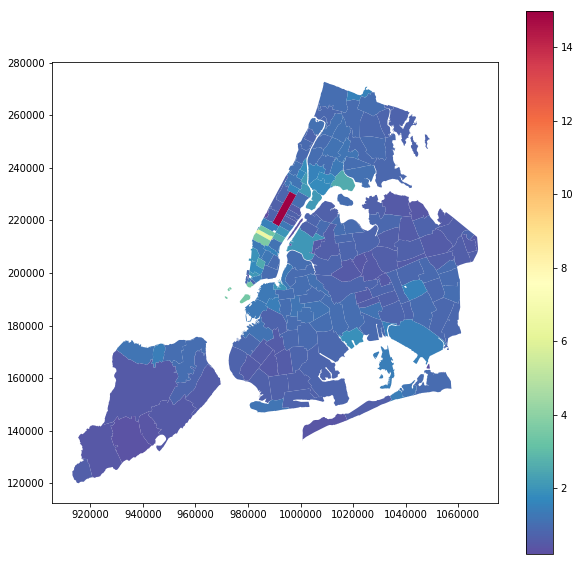

In [38]:
zipcode_crime_count_geo.plot(column='count_population',colormap='Spectral_r',legend=True,markersize=0.01,figsize=(10,10))

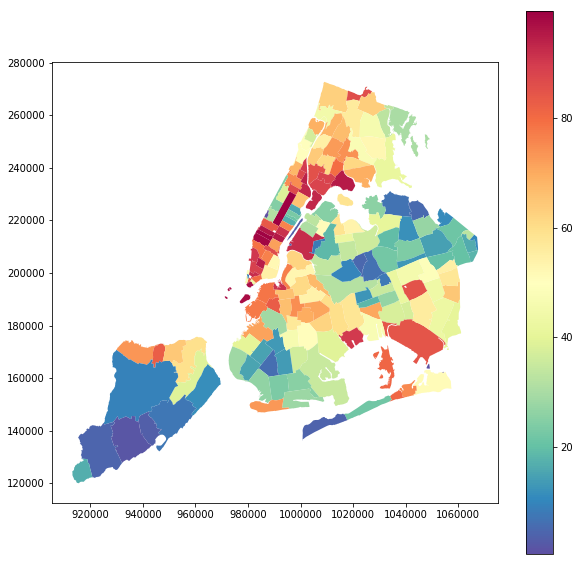

In [39]:
index_ = zipcode_crime_count_geo.count_population.values
zipcode_crime_count_geo["count_population_percentile"] = zipcode_crime_count_geo["count_population"].apply(lambda x:stats.percentileofscore(index_, x)) 
zipcode_crime_count_geo.plot(column='count_population_percentile',colormap='Spectral_r',legend=True, markersize=0.01,figsize=(10,10))

In [40]:
##  图中发现 有的 区域虽然crime数目多，但是那是因为他人多，而有的区域虽然犯罪数目少，但是crime的密度大，是值得引起注意的区域。

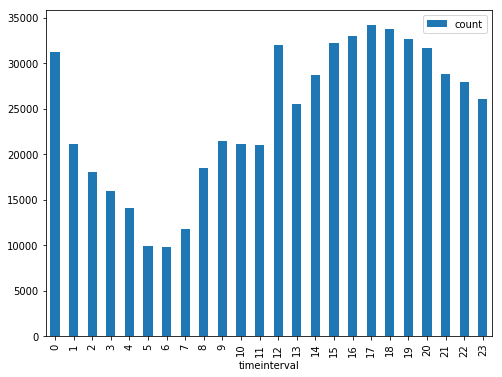

In [41]:
ti_crime_count = crimeData.groupby(["timeinterval"]).timeinterval.agg('count').to_frame('count').reset_index()
ti_crime_count.set_index(['timeinterval'],inplace=True)
ti_crime_count.plot(kind="bar", figsize=(8,6))

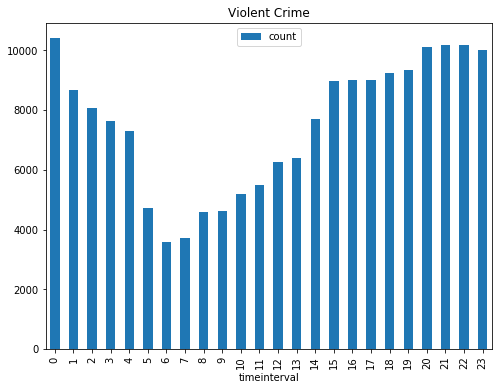

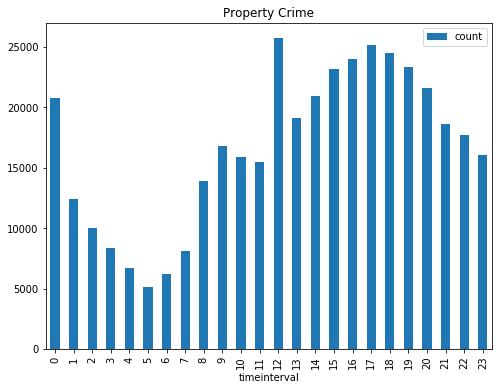

In [42]:
for name in crimeData.crime_name.unique():
    ti_crime_count_ = crimeData[crimeData.crime_name==name].groupby(["timeinterval"]).timeinterval.agg('count').to_frame('count').reset_index()
    ti_crime_count_.set_index(['timeinterval'],inplace=True)
    ti_crime_count_.plot(kind="bar", title=name,figsize=(8,6))

In [43]:
crimeData_weekday = crimeData[crimeData.isWeekend==0]
crimeData_weekend = crimeData[crimeData.isWeekend==1]
crimeData_weekday.head()

zipcode        date  year  month  timeinterval  isWeekend      crime_name  \
2  11231.0  08/14/2017  2017      8            21          0  Property Crime   
4  10019.0  03/17/2016  2016      3             0          0  Property Crime   
7  10301.0  12/28/2016  2016     12            17          0  Property Crime   
8  10010.0  12/04/2015  2015     12             1          0  Property Crime   
9  10033.0  07/20/2017  2017      7             8          0  Property Crime   

   crime_type  
2           2  
4           2  
7           2  
8           2  
9           2

In [44]:
crimeData_weekday_count = crimeData_weekday.groupby("zipcode").zipcode.agg('count').to_frame('count').reset_index()
crimeData_weekend_count = crimeData_weekend.groupby("zipcode").zipcode.agg('count').to_frame('count').reset_index()

In [45]:
zipcode_crime_count_weekday_geo = zipcode.merge(crimeData_weekday_count,left_on='ZIPCODE',right_on='zipcode',how='left')
zipcode_crime_count_weekend_geo = zipcode.merge(crimeData_weekend_count,left_on='ZIPCODE',right_on='zipcode',how='left')

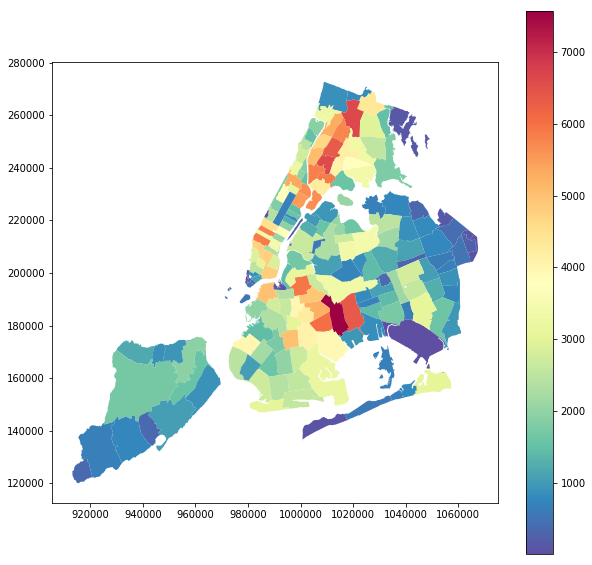

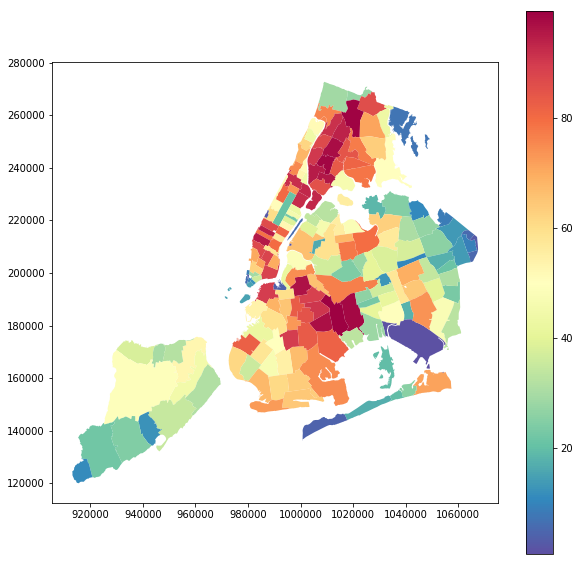

In [46]:
index_ = zipcode_crime_count_weekday_geo["count"].values
zipcode_crime_count_weekday_geo["count_percentile"] = zipcode_crime_count_weekday_geo["count"].apply(lambda x:stats.percentileofscore(index_, x)) 
zipcode_crime_count_weekday_geo.plot(column='count',colormap='Spectral_r',legend=True, markersize=0.01,figsize=(10,10))
zipcode_crime_count_weekday_geo.plot(column='count_percentile',colormap='Spectral_r',legend=True, markersize=0.01,figsize=(10,10))

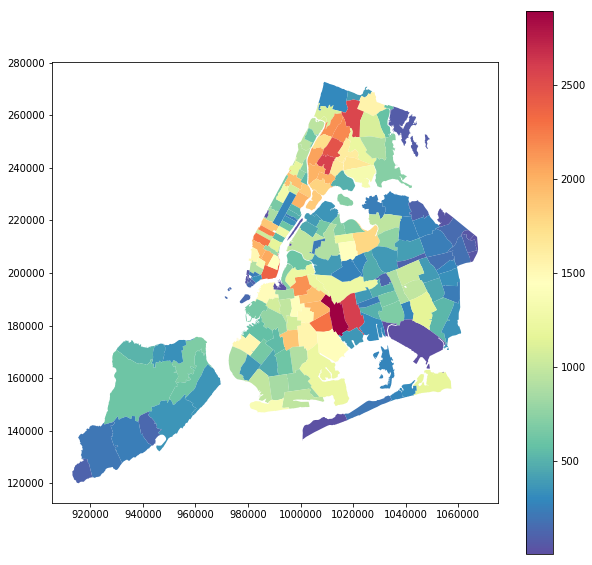

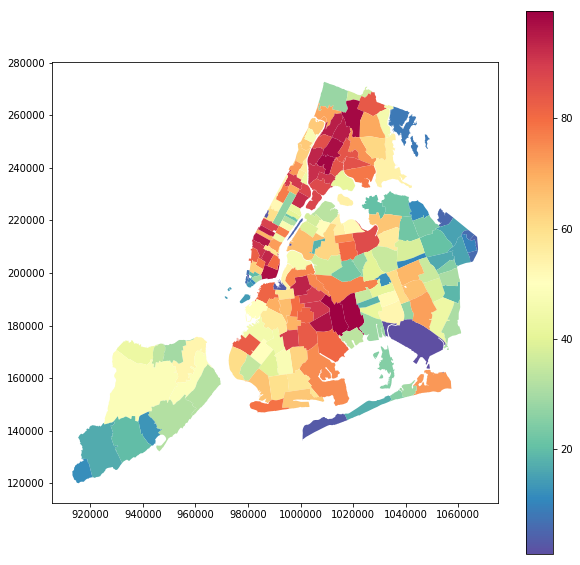

In [47]:
index_ = zipcode_crime_count_weekend_geo["count"].values
zipcode_crime_count_weekend_geo["count_percentile"] = zipcode_crime_count_weekend_geo["count"].apply(lambda x:stats.percentileofscore(index_, x)) 
zipcode_crime_count_weekend_geo.plot(column='count',colormap='Spectral_r',legend=True, markersize=0.01,figsize=(10,10))
zipcode_crime_count_weekend_geo.plot(column='count_percentile',colormap='Spectral_r',legend=True, markersize=0.01,figsize=(10,10))

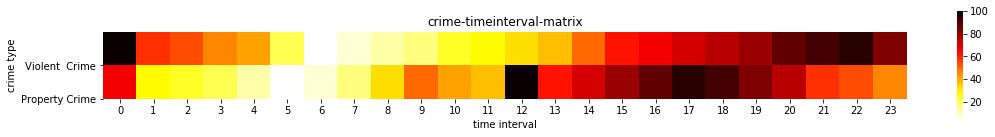

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt

crime_timeinterval = np.zeros((2, 24))

for type_ in sorted(crimeData.crime_type.unique()):
    ti_crime_count_ = crimeData[crimeData.crime_type==type_].groupby(["timeinterval"]).timeinterval.agg('count').to_frame('count').reset_index()
    ti_crime_count_.set_index(['timeinterval'],inplace=True)
    index_ = ti_crime_count_["count"].values
    type_count_percentile = ti_crime_count_["count"].apply(lambda x:stats.percentileofscore(index_, x)) 
    crime_timeinterval[type_-1,:] = type_count_percentile
    
    
f, ax = plt.subplots(figsize=(18, 2))
sns.heatmap(crime_timeinterval, cmap="hot_r", square=True)
plt.title("crime-timeinterval-matrix")
plt.yticks(np.arange(1, 3, 1),["Violent  Crime", "Property Crime"], rotation=0)
plt.xlabel("time interval")
plt.ylabel("crime type")
plt.show()

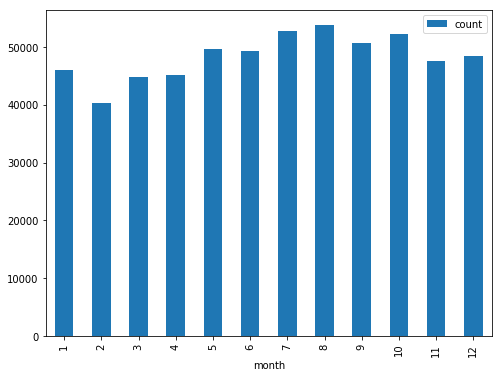

In [49]:
month_crime_count = crimeData.groupby(["month"]).month.agg('count').to_frame('count').reset_index()
month_crime_count.set_index(['month'],inplace=True)
month_crime_count.plot(kind="bar", figsize=(8,6))

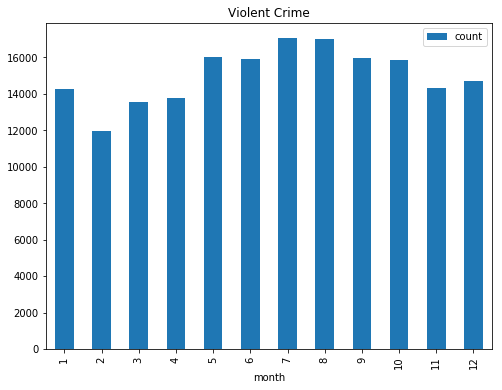

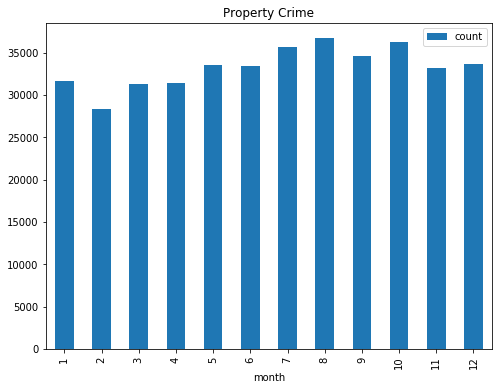

In [50]:
for name in crimeData.crime_name.unique():
    ti_crime_count_ = crimeData[crimeData.crime_name==name].groupby(["month"]).month.agg('count').to_frame('count').reset_index()
    ti_crime_count_.set_index(['month'],inplace=True)
    ti_crime_count_.plot(kind="bar", title=name,figsize=(8,6))

In [51]:
crimeData.head()

zipcode        date  year  month  timeinterval  isWeekend      crime_name  \
0  11213.0  07/23/2016  2016      7             2          1   Violent Crime   
1  10467.0  02/26/2017  2017      2             4          1   Violent Crime   
2  11231.0  08/14/2017  2017      8            21          0  Property Crime   
3  10037.0  09/18/2016  2016      9            23          1  Property Crime   
4  10019.0  03/17/2016  2016      3             0          0  Property Crime   

   crime_type  
0           1  
1           1  
2           2  
3           2  
4           2

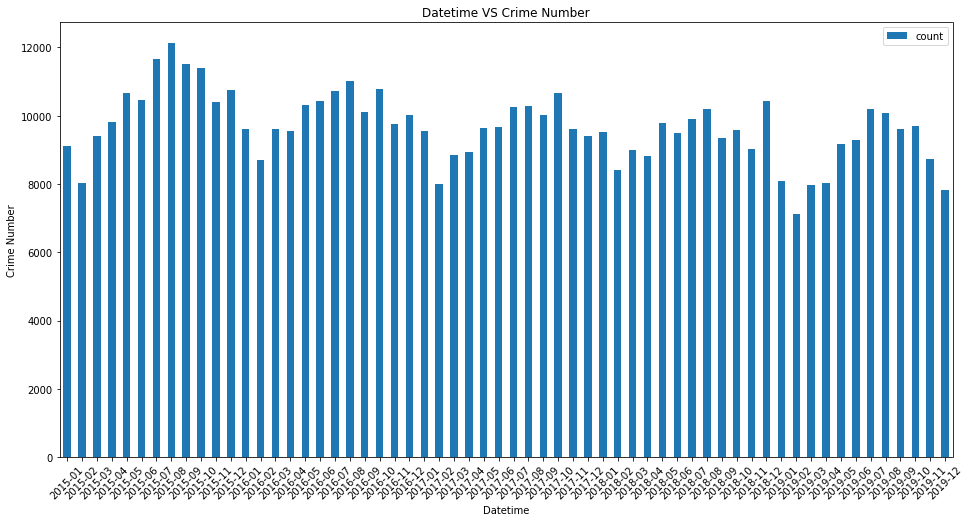

In [52]:
long_term_count = crimeData.groupby(["year", "month"]).month.agg('count').to_frame('count').reset_index()
ax = long_term_count[["count"]].plot(kind="bar",figsize=(16,8))

ax.set_xticklabels(x_labels)
plt.title("Datetime VS Crime Number")
plt.xlabel("Datetime")
plt.ylabel("Crime Number")
plt.xticks(rotation=45)
plt.show()

In [53]:
## 呈现周期性变化，且犯罪总体趋势逐年下降

### compute correlation

In [54]:
disorderData.head()

zipcode        date  year  month  timeinterval  isWeekend  \
0   11228  11/06/2017  2017     11            10          0   
1   10014  11/06/2017  2017     11             0          0   
2   11238  11/06/2017  2017     11            15          0   
3   10306  11/06/2017  2017     11            11          0   
4   11416  11/06/2017  2017     11             0          0   

          disorder_name  disorder_type  
0                Damage              5  
1                Damage              5  
2                Damage              5  
3                Damage              5  
4  Uncivil Use of Space              1

In [55]:
crimeData.head()

zipcode        date  year  month  timeinterval  isWeekend      crime_name  \
0  11213.0  07/23/2016  2016      7             2          1   Violent Crime   
1  10467.0  02/26/2017  2017      2             4          1   Violent Crime   
2  11231.0  08/14/2017  2017      8            21          0  Property Crime   
3  10037.0  09/18/2016  2016      9            23          1  Property Crime   
4  10019.0  03/17/2016  2016      3             0          0  Property Crime   

   crime_type  
0           1  
1           1  
2           2  
3           2  
4           2

In [56]:
date_disorder_count = disorderData.groupby(["date", "disorder_name"]).disorder_name.agg('count').to_frame('count').reset_index()

In [57]:
date_disorder_count.head()

date            disorder_name  count
0  01/01/2015                   Damage    126
1  01/01/2015           Drug & Alcohol      4
2  01/01/2015                 Graffiti      6
3  01/01/2015  Misdemeanor & Violation   1370
4  01/01/2015                    Noise   1208

In [58]:
date_disorder_count_pd = pd.pivot(date_disorder_count, index='date', columns='disorder_name')
date_disorder_count_pd.fillna(0, inplace=True)
date_disorder_count_pd.head()

count                                                          \
disorder_name Damage Drug & Alcohol Graffiti Misdemeanor & Violation   Noise   
date                                                                           
01/01/2015     126.0            4.0      6.0                  1370.0  1208.0   
01/01/2016     105.0            6.0      5.0                  1669.0  1527.0   
01/01/2017     112.0           14.0     11.0                  1589.0  1671.0   
01/01/2018     121.0           10.0      5.0                  1620.0  1351.0   
01/01/2019     165.0           16.0     21.0                  1498.0  1505.0   

                                                 
disorder_name Others Trash Uncivil Use of Space  
date                                             
01/01/2015       9.0   0.0                399.0  
01/01/2016      23.0   0.0                517.0  
01/01/2017      32.0   0.0                718.0  
01/01/2018      33.0   0.0                646.0  
01/01/2019      21.0   0.0                792.0

In [59]:
date_disorder_count_pd.index

Index(['01/01/2015', '01/01/2016', '01/01/2017', '01/01/2018', '01/01/2019',
       '01/02/2015', '01/02/2016', '01/02/2017', '01/02/2018', '01/02/2019',
       ...
       '12/30/2015', '12/30/2016', '12/30/2017', '12/30/2018', '12/30/2019',
       '12/31/2015', '12/31/2016', '12/31/2017', '12/31/2018', '12/31/2019'],
      dtype='object', name='date', length=1826)

In [60]:
date_crime_count = crimeData.groupby(["date", "crime_name"]).crime_name.agg('count').to_frame('count').reset_index()

In [61]:
date_crime_count_pd = pd.pivot(date_crime_count, index='date', columns='crime_name')
date_crime_count_pd.fillna(0, inplace=True)
date_crime_count_pd.head()

count              
crime_name Property Crime Violent Crime
date                                   
01/01/2015            235           182
01/01/2016            296           197
01/01/2017            276           174
01/01/2018            212           165
01/01/2019            217           130

In [62]:
disorder_crime_pd = date_disorder_count_pd.merge(date_crime_count_pd, on="date", how='left')

In [63]:
disorder_crime_pd

count                                                          \
disorder_name Damage Drug & Alcohol Graffiti Misdemeanor & Violation   Noise   
date                                                                           
01/01/2015     126.0            4.0      6.0                  1370.0  1208.0   
01/01/2016     105.0            6.0      5.0                  1669.0  1527.0   
01/01/2017     112.0           14.0     11.0                  1589.0  1671.0   
01/01/2018     121.0           10.0      5.0                  1620.0  1351.0   
01/01/2019     165.0           16.0     21.0                  1498.0  1505.0   
01/02/2015     294.0           16.0     54.0                   662.0   604.0   
01/02/2016     128.0            8.0     10.0                   811.0   933.0   
01/02/2017     230.0           12.0     12.0                   717.0   664.0   
01/02/2018     290.0           18.0     20.0                   777.0   474.0   
01/02/2019     569.0           21.0     55.0                   894.0   550.0   
01/03/2015      94.0            9.0     14.0                   655.0   900.0   
01/03/2016     228.0            9.0     15.0                   739.0  1004.0   
01/03/2017     389.0           11.0     18.0                   860.0   484.0   
01/03/2018     227.0           23.0    214.0                   861.0   436.0   
01/03/2019     495.0           24.0     33.0                   858.0   560.0   
01/04/2015     156.0            6.0     22.0                   609.0   921.0   
01/04/2016     430.0            9.0     64.0                   737.0   502.0   
01/04/2017     464.0           19.0    133.0                   879.0   567.0   
01/04/2018     103.0           19.0      7.0                   524.0   469.0   
01/04/2019     505.0           18.0     22.0                   934.0   739.0   
01/05/2015     422.0           16.0     43.0                   709.0   438.0   
01/05/2016     415.0           12.0     27.0                   742.0   443.0   
01/05/2017     470.0           20.0     75.0                   862.0   482.0   
01/05/2018     218.0            6.0     12.0                   791.0   616.0   
01/05/2019     239.0           16.0     17.0                   790.0  1000.0   
01/06/2015     467.0           12.0     54.0                   636.0   422.0   
01/06/2016     426.0           10.0     16.0                   879.0   462.0   
01/06/2017     258.0           18.0     61.0                   862.0   695.0   
01/06/2018     112.0           17.0     16.0                   722.0   884.0   
01/06/2019     272.0           16.0      3.0                   749.0  1044.0   
...              ...            ...      ...                     ...     ...   
12/26/2015     156.0            9.0      8.0                   788.0   965.0   
12/26/2016     232.0           11.0      6.0                   690.0   679.0   
12/26/2017     370.0           17.0     99.0                   695.0   511.0   
12/26/2018     323.0           13.0     16.0                   832.0   549.0   
12/26/2019     312.0           19.0    189.0                   683.0   729.0   
12/27/2015     199.0            8.0      9.0                   764.0  1026.0   
12/27/2016     370.0           21.0     41.0                   850.0   617.0   
12/27/2017     352.0           15.0     50.0                   759.0   555.0   
12/27/2018     388.0           16.0     38.0                   883.0   587.0   
12/27/2019     305.0           22.0    122.0                   726.0   871.0   
12/28/2015     409.0           11.0     18.0                   775.0   602.0   
12/28/2016     353.0           18.0     21.0                   798.0   712.0   
12/28/2017     270.0           24.0     29.0                   735.0   577.0   
12/28/2018     336.0           19.0    277.0                   977.0   703.0   
12/28/2019     184.0           19.0      8.0                   702.0  1203.0   
12/29/2015     342.0           13.0     27.0                   759.0   588.0   
12/29/2016     

In [64]:
final_disorder_crime_pd = pd.DataFrame()

In [65]:
final_disorder_crime_pd["date"] = disorder_crime_pd.index
final_disorder_crime_pd["Damage"] = disorder_crime_pd[("count", "Damage")].values
final_disorder_crime_pd["Drug & Alcohol"] = disorder_crime_pd[("count", "Drug & Alcohol")].values
final_disorder_crime_pd["Graffiti"] = disorder_crime_pd[("count", "Graffiti")].values
final_disorder_crime_pd["Misdemeanor & Violation"] = disorder_crime_pd[("count", "Misdemeanor & Violation")].values
final_disorder_crime_pd["Noise"] = disorder_crime_pd[("count", "Noise")].values
final_disorder_crime_pd["Others"] = disorder_crime_pd[("count", "Others")].values
final_disorder_crime_pd["Uncivil Use of Space"] = disorder_crime_pd[("count", "Uncivil Use of Space")].values
final_disorder_crime_pd["Property Crime"] = disorder_crime_pd[("count", "Property Crime")].values
final_disorder_crime_pd["Violent Crime"] = disorder_crime_pd[("count", "Violent Crime")].values

In [66]:
final_disorder_crime_pd["disorder"] = disorder_crime_pd[("count", "Damage")].values + disorder_crime_pd[("count", "Drug & Alcohol")].values + disorder_crime_pd[("count", "Graffiti")].values + disorder_crime_pd[("count", "Misdemeanor & Violation")].values +disorder_crime_pd[("count", "Noise")].values + disorder_crime_pd[("count", "Others")].values + disorder_crime_pd[("count", "Uncivil Use of Space")].values 
final_disorder_crime_pd["Crime"] = disorder_crime_pd[("count", "Property Crime")].values + disorder_crime_pd[("count", "Violent Crime")].values

In [67]:
final_disorder_crime_pd.head()

date  Damage  Drug & Alcohol  Graffiti  Misdemeanor & Violation  \
0  01/01/2015   126.0             4.0       6.0                   1370.0   
1  01/01/2016   105.0             6.0       5.0                   1669.0   
2  01/01/2017   112.0            14.0      11.0                   1589.0   
3  01/01/2018   121.0            10.0       5.0                   1620.0   
4  01/01/2019   165.0            16.0      21.0                   1498.0   

    Noise  Others  Uncivil Use of Space  Property Crime  Violent Crime  \
0  1208.0     9.0                 399.0             235            182   
1  1527.0    23.0                 517.0             296            197   
2  1671.0    32.0                 718.0             276            174   
3  1351.0    33.0                 646.0             212            165   
4  1505.0    21.0                 792.0             217            130   

   disorder  Crime  
0    3122.0    417  
1    3852.0    493  
2    4147.0    450  
3    3786.0    377  
4    4018.0    347

In [68]:
mat_corr = final_disorder_crime_pd.corr()

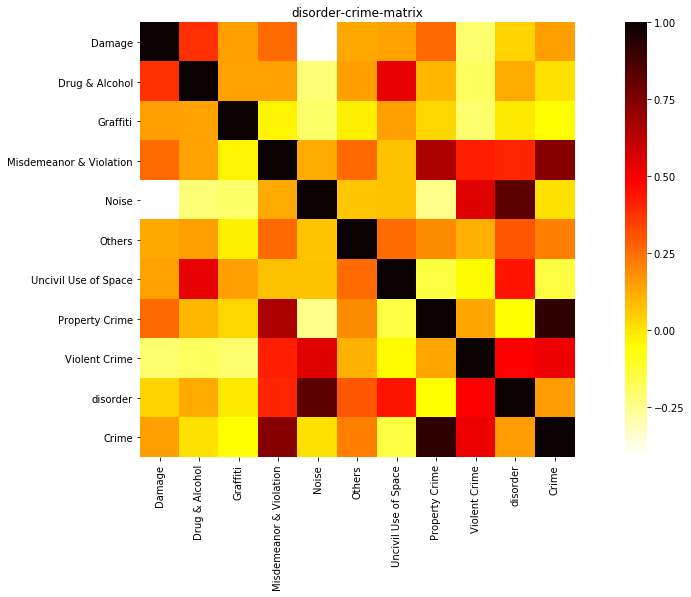

In [69]:
f, ax = plt.subplots(figsize=(18, 8))
sns.heatmap(mat_corr, cmap="hot_r", square=True)
plt.title("disorder-crime-matrix")
plt.show()

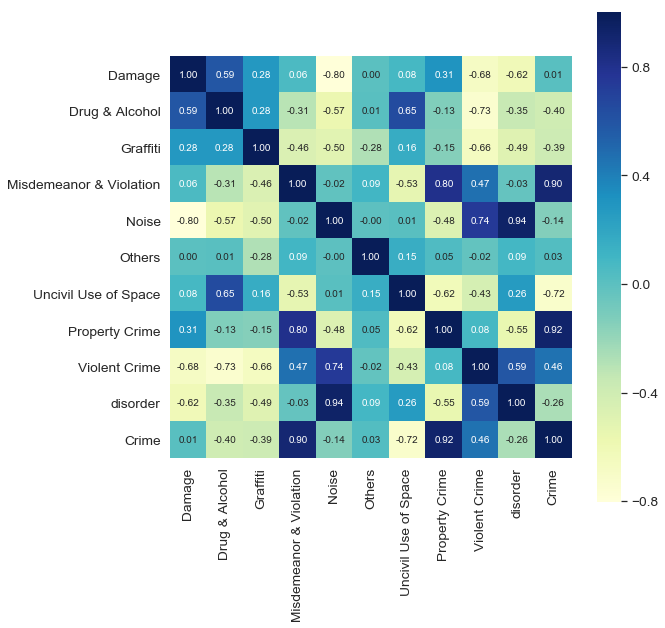

In [70]:
cols = mat_corr.columns
cm = np.corrcoef(mat_corr.values.T)
sns.set(font_scale=1.25)
f, ax = plt.subplots(figsize=(9, 9))
hm = sns.heatmap(cm, cbar=True, annot=True, cmap="YlGnBu",
                 square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols, xticklabels=cols)
plt.show()

## consider month

In [71]:
disorderData.head()

zipcode        date  year  month  timeinterval  isWeekend  \
0   11228  11/06/2017  2017     11            10          0   
1   10014  11/06/2017  2017     11             0          0   
2   11238  11/06/2017  2017     11            15          0   
3   10306  11/06/2017  2017     11            11          0   
4   11416  11/06/2017  2017     11             0          0   

          disorder_name  disorder_type  
0                Damage              5  
1                Damage              5  
2                Damage              5  
3                Damage              5  
4  Uncivil Use of Space              1

In [72]:
crimeData.head()

zipcode        date  year  month  timeinterval  isWeekend      crime_name  \
0  11213.0  07/23/2016  2016      7             2          1   Violent Crime   
1  10467.0  02/26/2017  2017      2             4          1   Violent Crime   
2  11231.0  08/14/2017  2017      8            21          0  Property Crime   
3  10037.0  09/18/2016  2016      9            23          1  Property Crime   
4  10019.0  03/17/2016  2016      3             0          0  Property Crime   

   crime_type  
0           1  
1           1  
2           2  
3           2  
4           2

In [209]:
date_disorder_count = disorderData.groupby(["zipcode", "year", "month", "disorder_name"]).disorder_name.agg('count').to_frame('count').reset_index()
date_disorder_count.head()

zipcode  year  month            disorder_name  count
0       0  2017      2                   Damage      1
1       1  2019      6                   Damage      1
2      11  2018      5                   Damage      1
3      83  2015      1  Misdemeanor & Violation     23
4      83  2015      1                    Noise      1

In [210]:
date_crime_count = crimeData.groupby(["zipcode", "year", "month", "crime_name"]).crime_name.agg('count').to_frame('count').reset_index()
date_crime_count.head()

zipcode  year  month      crime_name  count
0     83.0  2015      1  Property Crime      9
1     83.0  2015      1   Violent Crime      2
2     83.0  2015      2  Property Crime      5
3     83.0  2015      2   Violent Crime      2
4     83.0  2015      3  Property Crime      7

In [211]:
date_disorder_count.head()

zipcode  year  month            disorder_name  count
0       0  2017      2                   Damage      1
1       1  2019      6                   Damage      1
2      11  2018      5                   Damage      1
3      83  2015      1  Misdemeanor & Violation     23
4      83  2015      1                    Noise      1

In [212]:
date_disorder_count_pd = pd.pivot_table(date_disorder_count, index=["zipcode", "year", "month"], columns='disorder_name')
date_disorder_count_pd.fillna(0, inplace=True)
date_disorder_count_pd.head()

count                                                  \
disorder_name      Damage Drug & Alcohol Graffiti Misdemeanor & Violation   
zipcode year month                                                          
0.0     2017 2        1.0            0.0      0.0                     0.0   
1.0     2019 6        1.0            0.0      0.0                     0.0   
11.0    2018 5        1.0            0.0      0.0                     0.0   
83.0    2015 1        0.0            0.0      0.0                    23.0   
             2        0.0            0.0      0.0                    18.0   

                                                            
disorder_name      Noise Others Trash Uncivil Use of Space  
zipcode year month                                          
0.0     2017 2       0.0    0.0   0.0                  0.0  
1.0     2019 6       0.0    0.0   0.0                  0.0  
11.0    2018 5       0.0    0.0   0.0                  0.0  
83.0    2015 1       1.0    1.0   0.0                  0.0  
             2       3.0    0.0   0.0                  3.0

In [213]:
date_crime_count_pd = pd.pivot_table(date_crime_count, index=["zipcode", "year", "month"], columns='crime_name')
date_crime_count_pd.fillna(0, inplace=True)
date_crime_count_pd.head()

count              
crime_name         Property Crime Violent Crime
zipcode year month                             
83.0    2015 1                9.0           2.0
             2                5.0           2.0
             3                7.0           2.0
             4               12.0           3.0
             5               15.0           7.0

In [214]:
disorder_count_Index = []
for i in tqdm(date_disorder_count_pd.index):
    try:
        disorder_count_Index.append([int(i[0]), int(i[1]), int(i[2])])
    except:
        disorder_count_Index.append([-1, -1, -1])
disorder_count_Index = np.array(disorder_count_Index)

100%|██████████| 12691/12691 [00:00<00:00, 186718.55it/s]


In [215]:
crime_count_Index = []
for i in tqdm(date_crime_count_pd.index):
    crime_count_Index.append([int(i[0]), int(i[1]), int(i[2])])
    
crime_count_Index = np.array(crime_count_Index)

100%|██████████| 11044/11044 [00:00<00:00, 186805.93it/s]


In [216]:
zipcode_year_month_disorder_count = pd.DataFrame()
zipcode_year_month_crime_count = pd.DataFrame()

In [217]:
zipcode_year_month_disorder_count["zipcode"] = disorder_count_Index[:,0]
zipcode_year_month_disorder_count["year"] = disorder_count_Index[:,1]
zipcode_year_month_disorder_count["month"] = disorder_count_Index[:,2]

zipcode_year_month_disorder_count["Damage"] = date_disorder_count_pd.values[:,0]
zipcode_year_month_disorder_count["Drug & Alcohol"] = date_disorder_count_pd.values[:,1]
zipcode_year_month_disorder_count["Graffiti"] = date_disorder_count_pd.values[:,2]
zipcode_year_month_disorder_count["Misdemeanor & Violation"] = date_disorder_count_pd.values[:,3]
zipcode_year_month_disorder_count["Noise"] = date_disorder_count_pd.values[:,4]
zipcode_year_month_disorder_count["Others"] = date_disorder_count_pd.values[:,5]
zipcode_year_month_disorder_count["Trash"] = date_disorder_count_pd.values[:,6]
zipcode_year_month_disorder_count["Uncivil Use of Space"] = date_disorder_count_pd.values[:,7]

In [218]:
zipcode_year_month_crime_count["zipcode"] = crime_count_Index[:,0]
zipcode_year_month_crime_count["year"] = crime_count_Index[:,1]
zipcode_year_month_crime_count["month"] = crime_count_Index[:,2]

zipcode_year_month_crime_count["Property Crime"] = date_crime_count_pd.values[:,0]
zipcode_year_month_crime_count["Violent Crime"] = date_crime_count_pd.values[:,1]

In [219]:
zipcode_year_month_disorder_crime_pd = zipcode_year_month_disorder_count.merge(zipcode_year_month_crime_count, on = ["zipcode", "year", "month"])

In [220]:
zipcode_year_month_disorder_crime_pd = zipcode_year_month_disorder_crime_pd

In [221]:
mat_corr = zipcode_year_month_disorder_crime_pd[['Damage', 'Drug & Alcohol', 'Graffiti','Misdemeanor & Violation', 'Noise', 'Others', 'Trash', 'Uncivil Use of Space', 'Property Crime', 'Violent Crime']].corr()

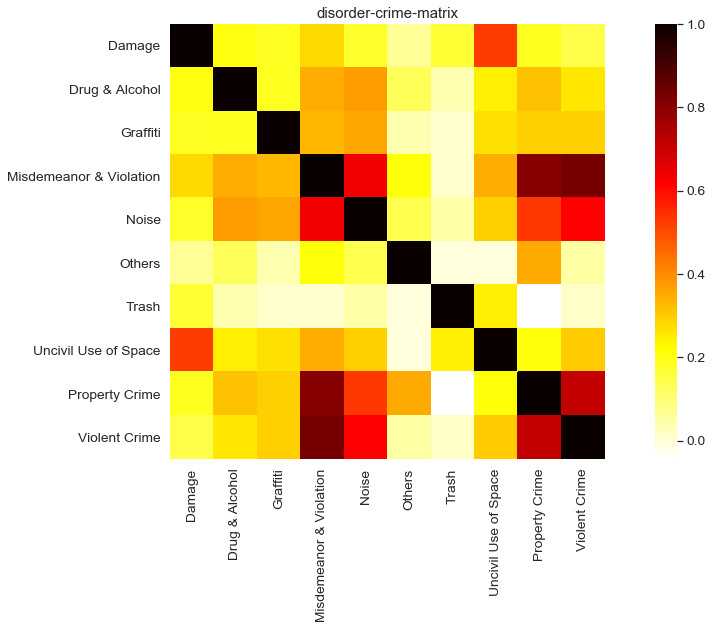

In [222]:
f, ax = plt.subplots(figsize=(18, 8))
sns.heatmap(mat_corr, cmap="hot_r", square=True)
plt.title("disorder-crime-matrix")
plt.show()

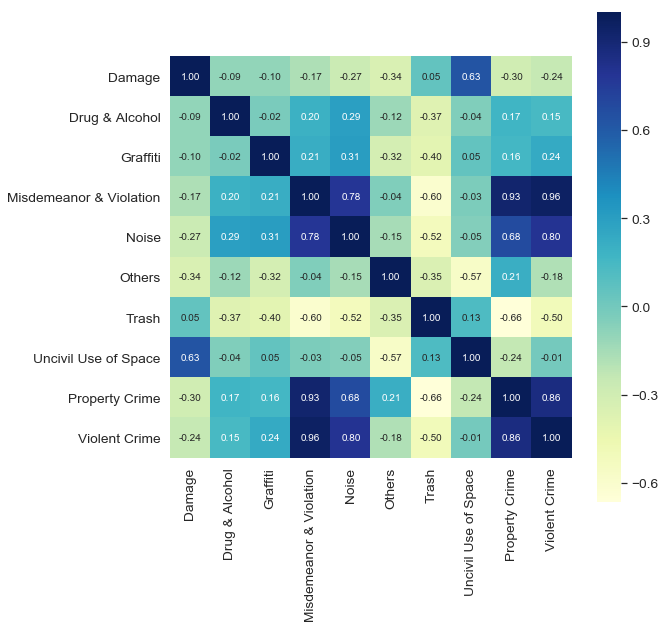

In [223]:
cols = mat_corr.columns
cm = np.corrcoef(mat_corr.values.T)
sns.set(font_scale=1.25)
f, ax = plt.subplots(figsize=(9, 9))
hm = sns.heatmap(cm, cbar=True, annot=True, cmap="YlGnBu",
                 square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols, xticklabels=cols)
plt.show()

In [225]:
len(zipcode_year_month_disorder_crime_pd.zipcode.unique())

191

In [226]:
zipcode_year_month_disorder_crime_pd.columns

Index(['zipcode', 'year', 'month', 'Damage', 'Drug & Alcohol', 'Graffiti',
       'Misdemeanor & Violation', 'Noise', 'Others', 'Trash',
       'Uncivil Use of Space', 'Property Crime', 'Violent Crime'],
      dtype='object')

In [227]:
year_month_disorder_crime_pd = zipcode_year_month_disorder_crime_pd[['year', 'month', 'Damage', 'Drug & Alcohol', 'Graffiti','Misdemeanor & Violation', 'Noise', 'Others', 'Trash','Uncivil Use of Space', 'Property Crime', 'Violent Crime']]
year_month_disorder_crime_pd.head()

year  month  Damage  Drug & Alcohol  Graffiti  Misdemeanor & Violation  \
0  2015      1     0.0             0.0       0.0                     23.0   
1  2015      2     0.0             0.0       0.0                     18.0   
2  2015      3     0.0             0.0       0.0                     21.0   
3  2015      4     0.0             0.0       0.0                     46.0   
4  2015      5     0.0             0.0       0.0                     58.0   

   Noise  Others  Trash  Uncivil Use of Space  Property Crime  Violent Crime  
0    1.0     1.0    0.0                   0.0             9.0            2.0  
1    3.0     0.0    0.0                   3.0             5.0            2.0  
2    9.0     0.0    0.0                   0.0             7.0            2.0  
3    8.0     0.0    0.0                   0.0            12.0            3.0  
4   19.0     0.0    0.0                   2.0            15.0            7.0

In [228]:
temporal_year_month_disorder_crime = year_month_disorder_crime_pd.groupby(["year", "month"])[['Damage', 'Drug & Alcohol', 'Graffiti',
       'Misdemeanor & Violation', 'Noise', 'Others', 'Trash',
       'Uncivil Use of Space', 'Property Crime', 'Violent Crime']]

In [229]:
year_month_count = []
for key, values in temporal_year_month_disorder_crime:
    _count = list(np.mean(values[['Damage', 'Drug & Alcohol', 'Graffiti','Misdemeanor & Violation', 'Noise', 'Others', 'Trash', 'Uncivil Use of Space', 'Property Crime', 'Violent Crime']]).values)
    year_month_count.append(_count)

In [230]:
year_month_count = np.array(year_month_count)

In [231]:
year_month_count_pd = pd.DataFrame()
year_month_count_pd["Damage"] = year_month_count[:,0]
year_month_count_pd["Drug & Alcohol"] = year_month_count[:,1]
year_month_count_pd["Graffiti"] = year_month_count[:,2]
year_month_count_pd["Misdemeanor & Violation"] = year_month_count[:,3]
year_month_count_pd["Noise"] = year_month_count[:,4]
year_month_count_pd["Others"] = year_month_count[:,5]
year_month_count_pd["Trash"] = year_month_count[:,6]
year_month_count_pd["Uncivil Use of Space"] = year_month_count[:,7]
year_month_count_pd["Property Crime"] = year_month_count[:,8]
year_month_count_pd["Violent Crime"] = year_month_count[:,9]

In [232]:
mat_corr = year_month_count_pd.corr()

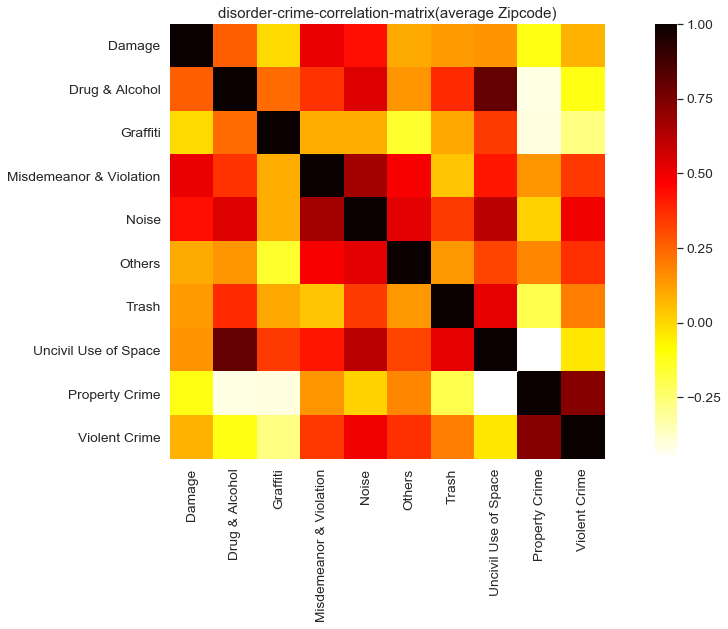

In [233]:
f, ax = plt.subplots(figsize=(18, 8))
sns.heatmap(mat_corr, cmap="hot_r", square=True)
plt.title("disorder-crime-correlation-matrix(average Zipcode)")
plt.show()

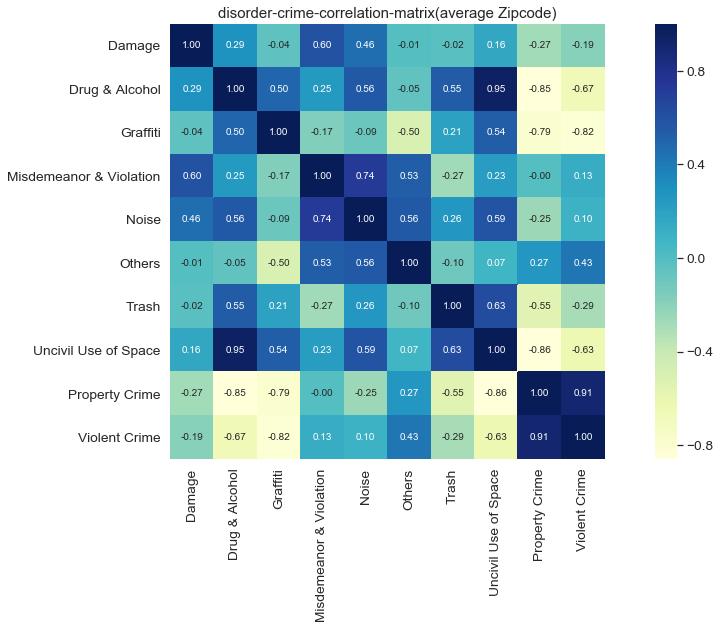

In [234]:
cols = mat_corr.columns
cm = np.corrcoef(mat_corr.values.T)
sns.set(font_scale=1.25)
f, ax = plt.subplots(figsize=(18, 8))
hm = sns.heatmap(cm, cbar=True, annot=True, cmap="YlGnBu",
                 square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols, xticklabels=cols)

plt.title("disorder-crime-correlation-matrix(average Zipcode)")
plt.show()

In [235]:
year_month_count_pd["human disorders"] = year_month_count_pd["Graffiti"] + year_month_count_pd["Damage"] + year_month_count_pd["Drug & Alcohol"] + year_month_count_pd["Misdemeanor & Violation"]

year_month_count_pd["environment disorders"] = year_month_count_pd["Noise"] + year_month_count_pd["Others"] + year_month_count_pd["Trash"] + year_month_count_pd["Uncivil Use of Space"]

In [236]:
human_environment_crime = year_month_count_pd[["human disorders", "environment disorders", "Property Crime", "Violent Crime"]]

In [237]:
mat_corr = human_environment_crime.corr()

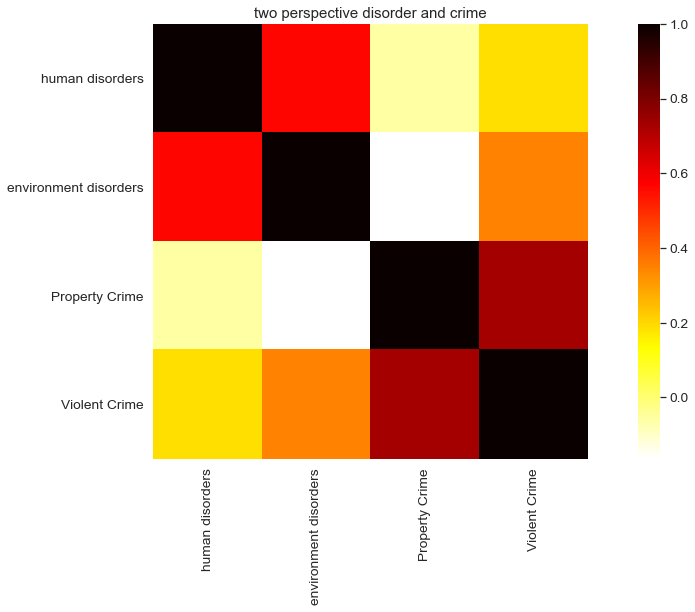

In [238]:
f, ax = plt.subplots(figsize=(18, 8))
sns.heatmap(mat_corr, cmap="hot_r", square=True)
plt.title("two perspective disorder and crime")
plt.show()

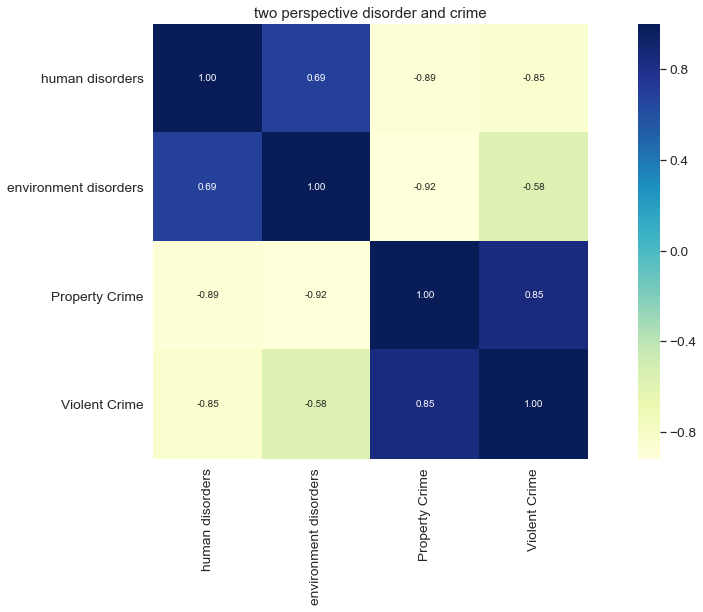

In [239]:
cols = mat_corr.columns
cm = np.corrcoef(mat_corr.values.T)
sns.set(font_scale=1.25)
f, ax = plt.subplots(figsize=(18, 8))
hm = sns.heatmap(cm, cbar=True, annot=True, cmap="YlGnBu",
                 square=True, fmt='.2f',vmax=1, annot_kws={'size': 10}, yticklabels=cols, xticklabels=cols)

plt.title("two perspective disorder and crime")
plt.show()

In [99]:
zipcode_year_month_disorder_crime_pd

zipcode  year  month  Damage  Drug & Alcohol  Graffiti  \
0           83  2015      1     0.0             0.0       0.0   
1           83  2015      2     0.0             0.0       0.0   
2           83  2015      3     0.0             0.0       0.0   
3           83  2015      4     0.0             0.0       0.0   
4           83  2015      5     0.0             0.0       0.0   
5           83  2015      6     0.0             0.0       0.0   
6           83  2015      7     0.0             0.0       0.0   
7           83  2015      8     0.0             0.0       0.0   
8           83  2015      9     1.0             0.0       0.0   
9           83  2015     10     0.0             0.0       0.0   
10          83  2015     10     0.0             0.0       0.0   
11          83  2015     11     0.0             0.0       0.0   
12          83  2015     12     1.0             0.0       0.0   
13          83  2016      1     1.0             0.0       0.0   
14          83  2016      2     0.0             0.0       0.0   
15          83  2016      3     0.0             0.0       0.0   
16          83  2016      4     2.0             0.0       0.0   
17          83  2016      5     0.0             0.0       0.0   
18          83  2016      6     0.0             0.0       0.0   
19          83  2016      7     0.0             0.0       0.0   
20          83  2016      8     0.0             0.0       0.0   
21          83  2016      9     0.0             0.0       0.0   
22          83  2016     10     0.0             0.0       0.0   
23          83  2016     11     0.0             0.0       0.0   
24          83  2016     12     0.0             0.0       0.0   
25          83  2017      1     0.0             0.0       0.0   
26          83  2017      2     0.0             0.0       0.0   
27          83  2017      3     1.0             0.0       0.0   
28          83  2017      4     2.0             0.0       0.0   
29          83  2017      5     0.0             0.0       0.0   
...        ...   ...    ...     ...             ...       ...   
11347    11697  2016      2     4.0             0.0       0.0   
11348    11697  2016      4     0.0             0.0       0.0   
11349    11697  2016      5     0.0             0.0       0.0   
11350    11697  2016      6     1.0             0.0       0.0   
11351    11697  2016      7     1.0             0.0       0.0   
11352    11697  2016      8     1.0             0.0       0.0   
11353    11697  2016      9     0.0             0.0       0.0   
11354    11697  2016     10     0.0             0.0       0.0   
11355    11697  2016     11     0.0             0.0       0.0   
11356    11697  2016     12     2.0             0.0       0.0   
11357    11697  2017      1     1.0             0.0       0.0   
11358    11697  2017      6     1.0             0.0       0.0   
11359    11697  2017      7     1.0             0.0       0.0   
11360    11697  2017      9     0.0             0.0       0.0   
11361    11697  2017     10     1.0             0.0       0.0   
11362    11697  2017     11     0.0             0.0       0.0   
11363    11697  2017     12     1.0             0.0       0.0   
11364    11697  2018      2     2.0             0.0       0.0   
11365    11697  2018      3     4.0             0.0       0.0   
11366    11697  2018      4     0.0             0.0       0.0   
11367    11697  2018      5     0.0             0.0       0.0   
11368    11697  2018      7     0.0             2.0       0.0   
11369    11697  2018      8     1.0             0.0       0.0   
11370    11697  2018      9     1.0             1.0       0.0   
11371    11697  2018     10     1.0             0.0       0.0   
11372    11697  2018     11     0.0             0.0       1.0   
11373    11697  2018     12     2.0             0.0       0.0   
11374    11697  2019      3     2.0             0.0       1.0   
11375    11697  2019      5     1.0             0.0       0.0   
11376    11697  2019     12     0.0       

2. 分析不同zipcode下不同disorder与crime之间的关系 （仍然以百分位的形式在地图上进行可视化） （spatial information）

其中，
1. disorder ： Trash 和	Uncivil Use of Space
2. crime ： Property Crime 和	Violent Crime

In [100]:
zipcode_year_disorder_crime_group = zipcode_year_month_disorder_crime_pd.groupby(["zipcode", "month"])['Damage', 'Drug & Alcohol', 'Graffiti',
       'Misdemeanor & Violation', 'Noise', 'Others', 'Trash',
       'Uncivil Use of Space', 'Property Crime', 'Violent Crime']

In [101]:
zipcode_month_disorder_crime_count = []
for key, values in zipcode_year_disorder_crime_group:
    zipcode, month = key
    zipcode_month = [zipcode, month]
    _count = list(np.mean(values[['Damage', 'Drug & Alcohol', 'Graffiti','Misdemeanor & Violation', 'Noise', 'Others', 'Trash', 'Uncivil Use of Space', 'Property Crime', 'Violent Crime']]).values)
    zipcode_month_count = zipcode_month + _count
    zipcode_month_disorder_crime_count.append(zipcode_month_count)

In [102]:
zipcode_month_disorder_crime_count = np.array(zipcode_month_disorder_crime_count)

In [103]:
zipcode_month_disorder_crime_count[0]

array([83. ,  1. ,  0.4,  0. ,  0. , 22.4,  0.2,  0.4,  0. ,  0. ,  8.2,
        2.8])

In [104]:
zipcode_year_month_disorder_crime_average_pd = pd.DataFrame()
zipcode_year_month_disorder_crime_average_pd["zipcode"] = zipcode_month_disorder_crime_count[:,0]
zipcode_year_month_disorder_crime_average_pd["month"] = zipcode_month_disorder_crime_count[:,1]

zipcode_year_month_disorder_crime_average_pd["Damage"] = zipcode_month_disorder_crime_count[:,2]
zipcode_year_month_disorder_crime_average_pd["Drug & Alcohol"] = zipcode_month_disorder_crime_count[:,3]
zipcode_year_month_disorder_crime_average_pd["Graffiti"] = zipcode_month_disorder_crime_count[:,4]
zipcode_year_month_disorder_crime_average_pd["Misdemeanor & Violation"] = zipcode_month_disorder_crime_count[:,5]
zipcode_year_month_disorder_crime_average_pd["Noise"] = zipcode_month_disorder_crime_count[:,6]
zipcode_year_month_disorder_crime_average_pd["Others"] = zipcode_month_disorder_crime_count[:,7]
zipcode_year_month_disorder_crime_average_pd["Trash"] = zipcode_month_disorder_crime_count[:,8]
zipcode_year_month_disorder_crime_average_pd["Uncivil Use of Space"] = zipcode_month_disorder_crime_count[:,9]
zipcode_year_month_disorder_crime_average_pd["Property Crime"] = zipcode_month_disorder_crime_count[:,10]
zipcode_year_month_disorder_crime_average_pd["Violent Crime"] = zipcode_month_disorder_crime_count[:,11]

In [105]:
zipcode_year_month_disorder_crime_average_pd[zipcode_year_month_disorder_crime_average_pd.zipcode==83].corr()

zipcode         month    Damage  Drug & Alcohol  \
zipcode                      NaN           NaN       NaN             NaN   
month                        NaN  1.000000e+00 -0.275946             NaN   
Damage                       NaN -2.759458e-01  1.000000             NaN   
Drug & Alcohol               NaN           NaN       NaN             NaN   
Graffiti                     NaN           NaN       NaN             NaN   
Misdemeanor & Violation      NaN  2.132043e-01 -0.211400             NaN   
Noise                        NaN -4.729948e-02 -0.057377             NaN   
Others                       NaN  2.403844e-17 -0.091542             NaN   
Trash                        NaN           NaN       NaN             NaN   
Uncivil Use of Space         NaN -2.556475e-01  0.178426             NaN   
Property Crime               NaN  3.935105e-01 -0.237054             NaN   
Violent Crime                NaN  4.229549e-01 -0.270940             NaN   

                         Graffiti  Misdemeanor & Violation     Noise  \
zipcode                       NaN                      NaN       NaN   
month                         NaN                 0.213204 -0.047299   
Damage                        NaN                -0.211400 -0.057377   
Drug & Alcohol                NaN                      NaN       NaN   
Graffiti                      NaN                      NaN       NaN   
Misdemeanor & Violation       NaN                 1.000000  0.470854   
Noise                         NaN                 0.470854  1.000000   
Others                        NaN                 0.747569  0.169004   
Trash                         NaN                      NaN       NaN   
Uncivil Use of Space          NaN                 0.296990  0.512736   
Property Crime                NaN                 0.931987  0.257424   
Violent Crime                 NaN                 0.825546  0.154397   

                               Others  Trash  Uncivil Use of Space  \
zipcode                           NaN    NaN                   NaN   
month                    2.403844e-17    NaN             -0.255648   
Damage                  -9.154173e-02    NaN              0.178426   
Drug & Alcohol                    NaN    NaN                   NaN   
Graffiti                          NaN    NaN                   NaN   
Misdemeanor & Violation  7.475691e-01    NaN              0.296990   
Noise                    1.690042e-01    NaN              0.512736   
Others                   1.000000e+00    NaN             -0.036436   
Trash                             NaN    NaN                   NaN   
Uncivil Use of Space    -3.643604e-02    NaN              1.000000   
Property Crime           6.815324e-01    NaN              0.275483   
Violent Crime            5.238250e-01    NaN              0.202147   

                         Property Crime  Violent Crime  
zipcode                             NaN            NaN  
month                          0.393510       0.422955  
Damage                        -0.237054      -0.270940  
Drug & Alcohol                      NaN            NaN  
Graffiti                            NaN            NaN  
Misdemeanor & Violation        0.931987       0.825546  
Noise                          0.257424       0.154397  
Others                         0.681532       0.523825  
Trash                               NaN            NaN  
Uncivil Use of Space           0.275483       0.202147  
Property Crime                 1.000000       0.933711  
Violent Crime                  0.933711       1.000000

In [106]:
zipcode_disorder_crime_corr = []

for zipcode in tqdm(zipcode_year_month_disorder_crime_average_pd.zipcode.unique()):
    zipcodeInData = zipcode_year_month_disorder_crime_average_pd[zipcode_year_month_disorder_crime_average_pd.zipcode == zipcode]
    corr = zipcodeInData.corr()
    corr.fillna(0, inplace=True)
    trash_Property = corr.values[10,8]
    Uncivil_Property = corr.values[10,9]
    trash_Violent = corr.values[11,8]
    Uncivil_Violent = corr.values[11,9]
    zipcode_disorder_crime_corr.append([zipcode, trash_Property, Uncivil_Property, trash_Violent, Uncivil_Violent])
    

100%|██████████| 191/191 [00:00<00:00, 297.02it/s]


In [107]:
zipcode_disorder_crime_corr = np.array(zipcode_disorder_crime_corr)

In [108]:
zipcode_disorder_crime_corr_pd = pd.DataFrame()

In [109]:
zipcode_disorder_crime_corr_pd["ZIPCODE"] = zipcode_disorder_crime_corr[:,0]
zipcode_disorder_crime_corr_pd["trash_Property"] = zipcode_disorder_crime_corr[:,1]
zipcode_disorder_crime_corr_pd["Uncivil_Property"] = zipcode_disorder_crime_corr[:,2]
zipcode_disorder_crime_corr_pd["trash_Violent"] = zipcode_disorder_crime_corr[:,3]
zipcode_disorder_crime_corr_pd["Uncivil_Violent"] = zipcode_disorder_crime_corr[:,4]

In [110]:
#load the resulting shapefile using geopandas
zipcode = gpd.read_file('../Data/ZIPCODE/ZIP_CODE_040114.shp')
zipcode.head()

ZIPCODE BLDGZIP   PO_NAME  POPULATION          AREA STATE  COUNTY ST_FIPS  \
0   11436       0   Jamaica     18681.0  2.269930e+07    NY  Queens      36   
1   11213       0  Brooklyn     62426.0  2.963100e+07    NY   Kings      36   
2   11212       0  Brooklyn     83866.0  4.197210e+07    NY   Kings      36   
3   11225       0  Brooklyn     56527.0  2.369863e+07    NY   Kings      36   
4   11218       0  Brooklyn     72280.0  3.686880e+07    NY   Kings      36   

  CTY_FIPS                   URL  SHAPE_AREA  SHAPE_LEN  \
0      081  http://www.usps.com/         0.0        0.0   
1      047  http://www.usps.com/         0.0        0.0   
2      047  http://www.usps.com/         0.0        0.0   
3      047  http://www.usps.com/         0.0        0.0   
4      047  http://www.usps.com/         0.0        0.0   

                                            geometry  
0  POLYGON ((1038098.252 188138.380, 1038141.936 ...  
1  POLYGON ((1001613.713 186926.440, 1002314.243 ...  
2  POLYGON ((1011174.276 183696.338, 1011373.584 ...  
3  POLYGON ((995908.365 183617.613, 996522.848 18...  
4  POLYGON ((991997.113 176307.496, 992042.798 17...

In [111]:
type(zipcode)

geopandas.geodataframe.GeoDataFrame

In [112]:
zipcode["ZIPCODE"] = zipcode["ZIPCODE"].astype(np.float64)

In [113]:
zipcode_disorder_crime_corr_pd_geo = zipcode.merge(zipcode_disorder_crime_corr_pd, on="ZIPCODE", how="left")

In [114]:
zipcode_disorder_crime_corr_pd.columns

Index(['ZIPCODE', 'trash_Property', 'Uncivil_Property', 'trash_Violent',
       'Uncivil_Violent'],
      dtype='object')

##  Trash&Property Crime

In [115]:
zipcode_disorder_crime_corr_pd_geo.columns

Index(['ZIPCODE', 'BLDGZIP', 'PO_NAME', 'POPULATION', 'AREA', 'STATE',
       'COUNTY', 'ST_FIPS', 'CTY_FIPS', 'URL', 'SHAPE_AREA', 'SHAPE_LEN',
       'geometry', 'trash_Property', 'Uncivil_Property', 'trash_Violent',
       'Uncivil_Violent'],
      dtype='object')

Text(0.5, 1.0, 'spatial distribution between Trash and Property Crime')

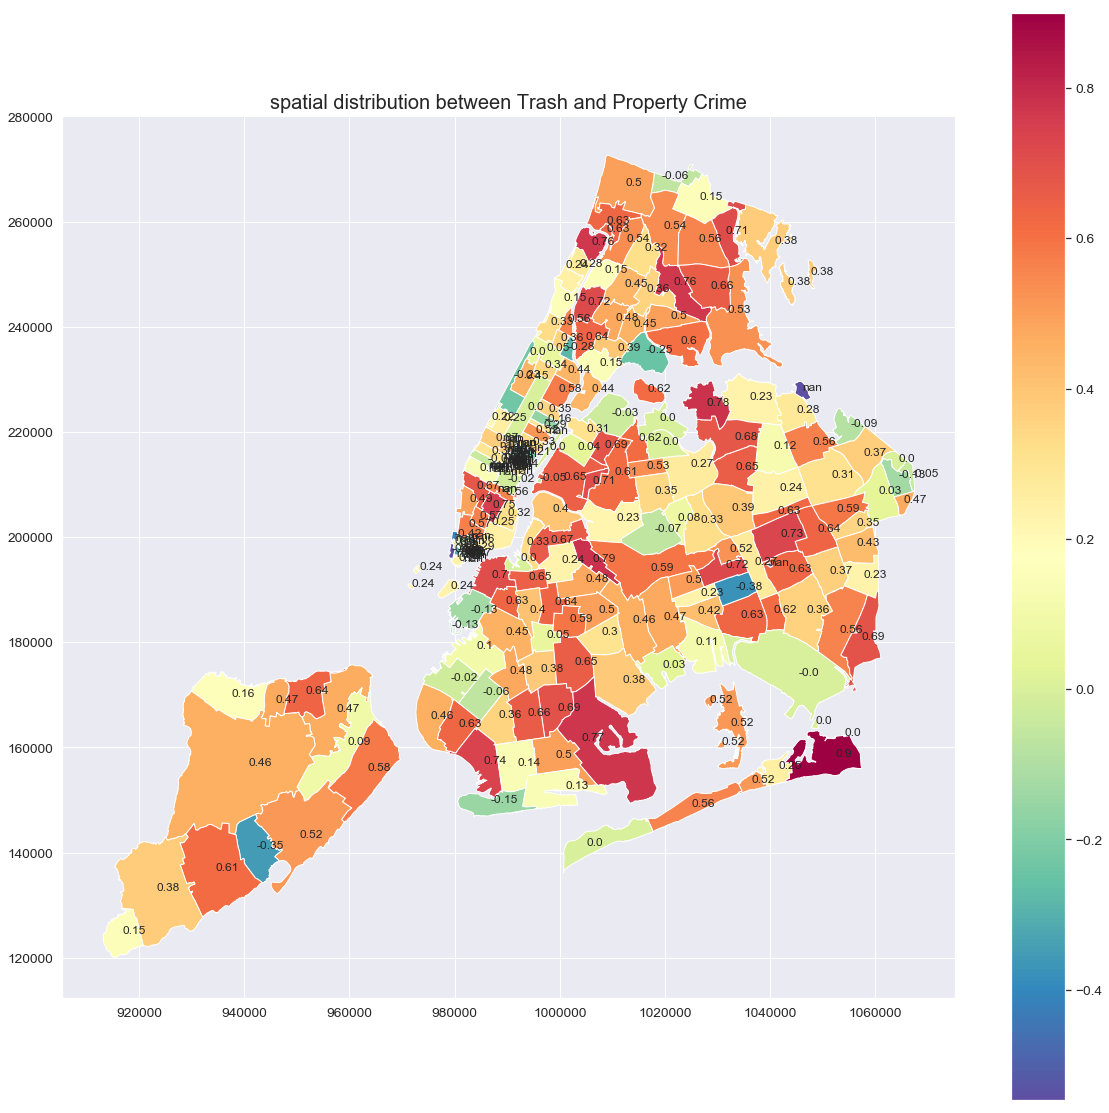

In [116]:
# index_ = zipcode_disorder_crime_corr_pd_geo["trash_Property"].values
# zipcode_disorder_crime_corr_pd_geo["trash_Property_percentile"] = zipcode_disorder_crime_corr_pd_geo["trash_Property"].apply(lambda x:stats.percentileofscore(index_, x)) 

zipcode_disorder_crime_corr_pd_geo.plot(column='trash_Property',colormap='Spectral_r',legend=True,markersize=0.01,figsize=(20,20))

zipcode_disorder_crime_corr_pd_geo['coords'] = zipcode_disorder_crime_corr_pd_geo['geometry'].apply(lambda x: x.representative_point().coords[0])
for n, i in enumerate(zipcode_disorder_crime_corr_pd_geo['coords']):
    plt.text(i[0]-0.2, i[1], round(zipcode_disorder_crime_corr_pd_geo['trash_Property'][n], 2), fontsize=12, horizontalalignment="left")  # 标注位置X，Y，标注内容
    
plt.title("spatial distribution between Trash and Property Crime",fontsize=20 )    

##  Uncivil Use of Space& Property Crime

Text(0.5, 1.0, 'spatial distribution between Uncivil Use of Space and Property Crime')

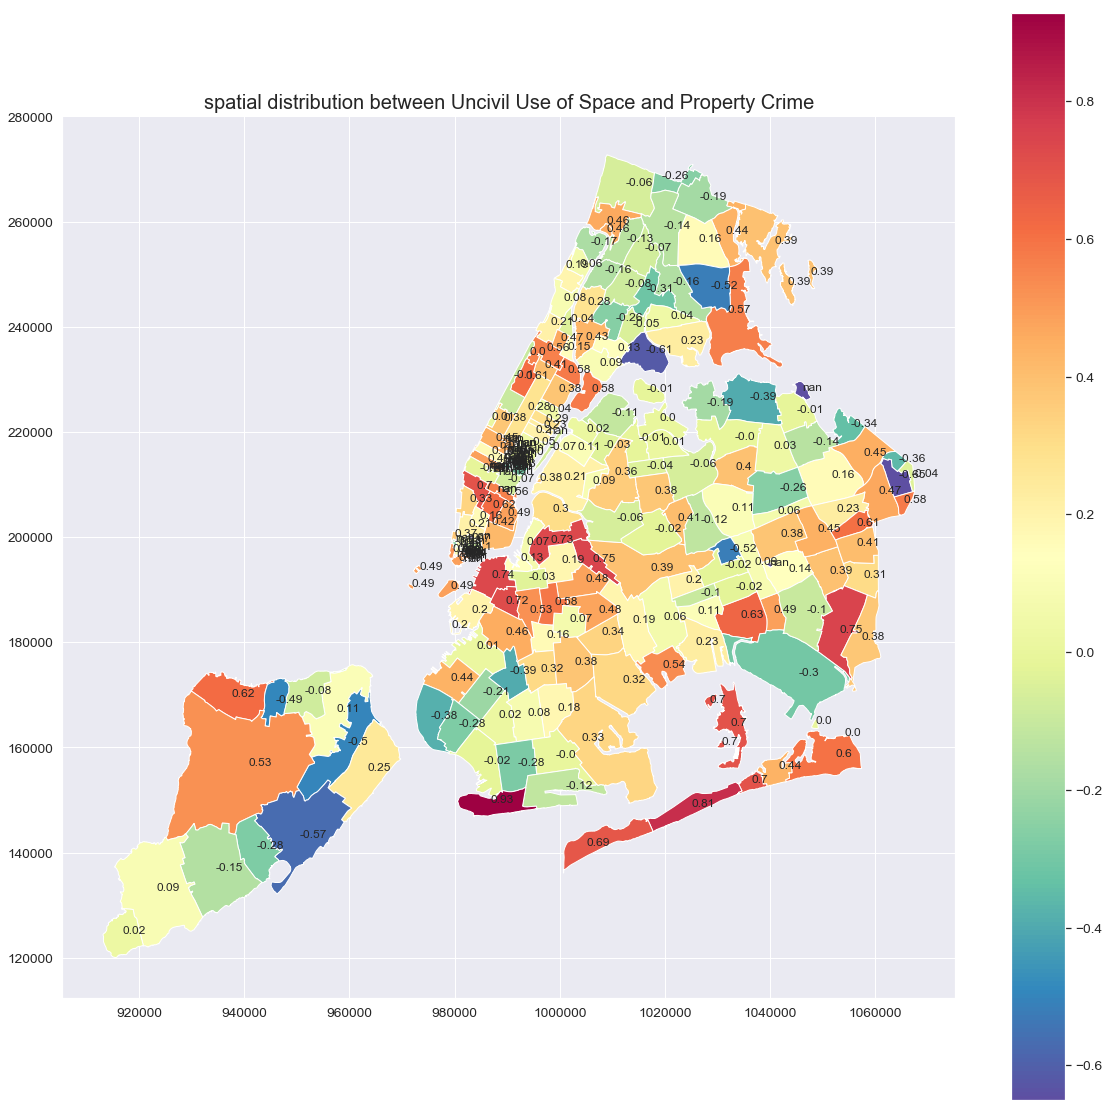

In [117]:
# index_ = zipcode_disorder_crime_corr_pd_geo["Uncivil_Property"].values
# zipcode_disorder_crime_corr_pd_geo["Uncivil_Property_percentile"] = zipcode_disorder_crime_corr_pd_geo["Uncivil_Property"].apply(lambda x:stats.percentileofscore(index_, x)) 

zipcode_disorder_crime_corr_pd_geo.plot(column='Uncivil_Property',colormap='Spectral_r',legend=True,markersize=0.01,figsize=(20,20))
for n, i in enumerate(zipcode_disorder_crime_corr_pd_geo['coords']):
    plt.text(i[0], i[1], round(zipcode_disorder_crime_corr_pd_geo['Uncivil_Property'][n], 2), fontsize=12, horizontalalignment="left")  # 标注位置X，Y，标注内容
    
    
plt.title("spatial distribution between Uncivil Use of Space and Property Crime",fontsize=20 )  

## Trash &Violent Crime

Text(0.5, 1.0, 'spatial distribution between Trash and Violent Crime')

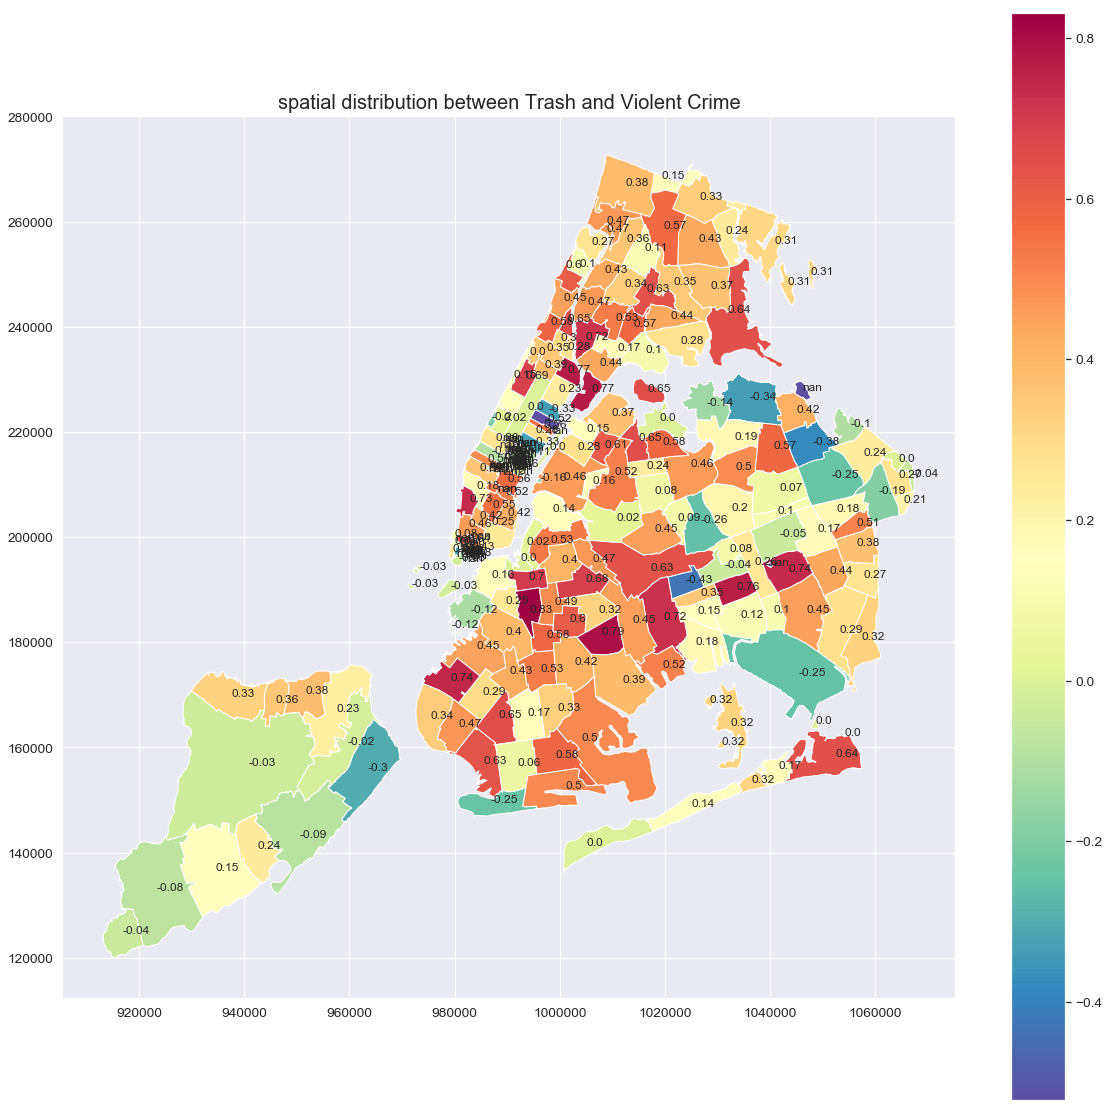

In [118]:
# index_ = zipcode_disorder_crime_corr_pd_geo["trash_Violent"].values
# zipcode_disorder_crime_corr_pd_geo["trash_Violent_percentile"] = zipcode_disorder_crime_corr_pd_geo["trash_Violent"].apply(lambda x:stats.percentileofscore(index_, x)) 

zipcode_disorder_crime_corr_pd_geo.plot(column='trash_Violent',colormap='Spectral_r',legend=True,markersize=0.01,figsize=(20,20))

for n, i in enumerate(zipcode_disorder_crime_corr_pd_geo['coords']):
    plt.text(i[0], i[1], round(zipcode_disorder_crime_corr_pd_geo['trash_Violent'][n], 2), fontsize=12, horizontalalignment="left")  # 标注位置X，Y，标注内容
    
    
plt.title("spatial distribution between Trash and Violent Crime",fontsize=20 ) 

## Uncivil Use of Space &Violent Crime

Text(0.5, 1.0, 'spatial distribution between Uncivil Use of Space and Violent Crime')

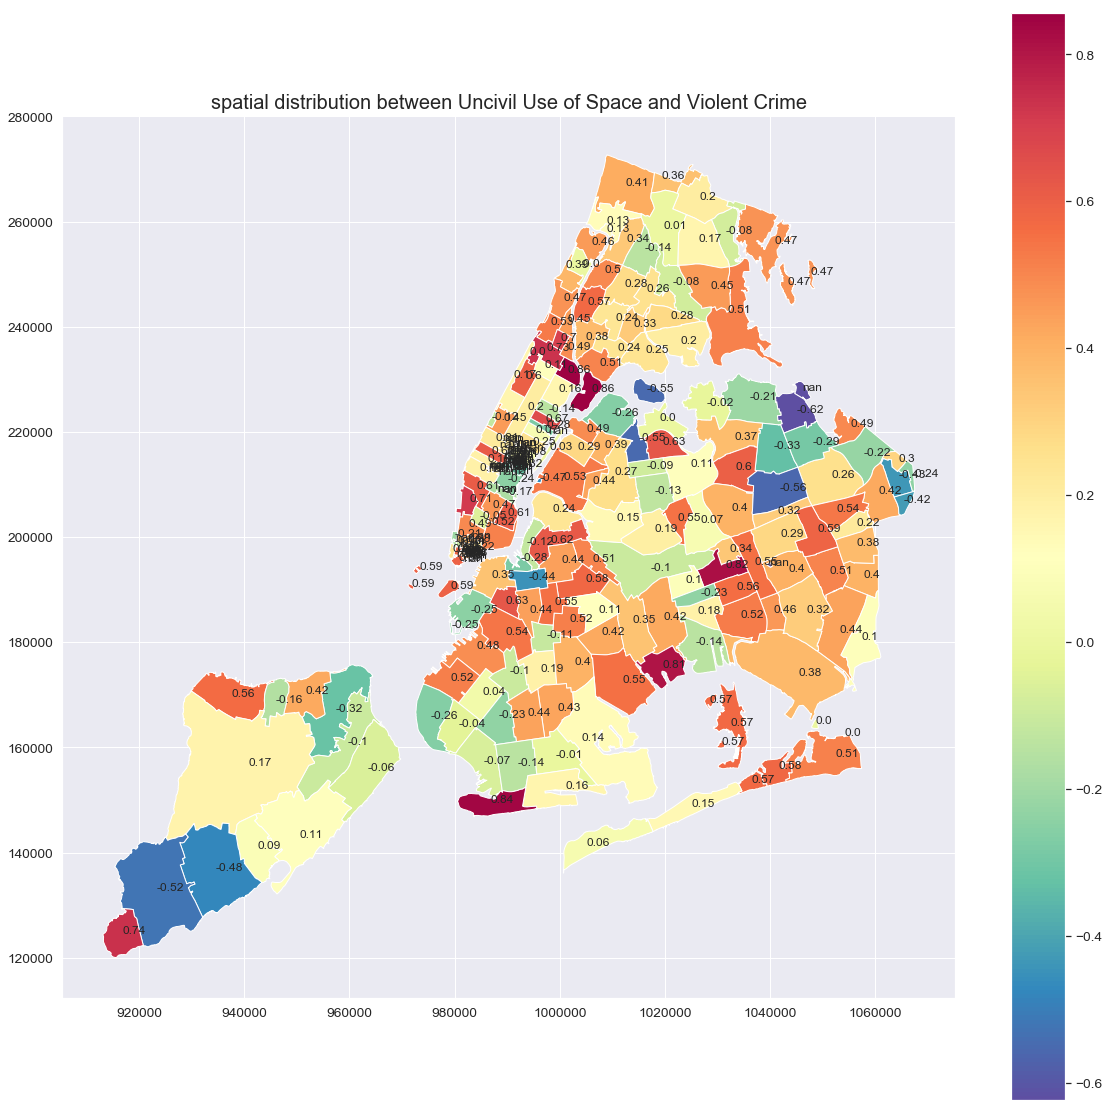

In [119]:
# index_ = zipcode_disorder_crime_corr_pd_geo["Uncivil_Violent"].values
# zipcode_disorder_crime_corr_pd_geo["Uncivil_Violent_percentile"] = zipcode_disorder_crime_corr_pd_geo["Uncivil_Violent"].apply(lambda x:stats.percentileofscore(index_, x)) 

zipcode_disorder_crime_corr_pd_geo.plot(column='Uncivil_Violent',colormap='Spectral_r',legend=True,markersize=0.01,figsize=(20,20))

for n, i in enumerate(zipcode_disorder_crime_corr_pd_geo['coords']):
    plt.text(i[0], i[1], round(zipcode_disorder_crime_corr_pd_geo['Uncivil_Violent'][n], 2), fontsize=12, horizontalalignment="left")  
    
plt.title("spatial distribution between Uncivil Use of Space and Violent Crime",fontsize=20 ) 

In [120]:
zipcode_disorder_crime_corr_pd_geo = zipcode.merge(zipcode_disorder_crime_corr_pd, on="ZIPCODE", how="left")

In [121]:
zipcode_disorder_crime_corr_pd.columns

Index(['ZIPCODE', 'trash_Property', 'Uncivil_Property', 'trash_Violent',
       'Uncivil_Violent'],
      dtype='object')

##  trash & Property Crime

In [122]:
zipcode_disorder_crime_corr_pd_geo.columns

Index(['ZIPCODE', 'BLDGZIP', 'PO_NAME', 'POPULATION', 'AREA', 'STATE',
       'COUNTY', 'ST_FIPS', 'CTY_FIPS', 'URL', 'SHAPE_AREA', 'SHAPE_LEN',
       'geometry', 'trash_Property', 'Uncivil_Property', 'trash_Violent',
       'Uncivil_Violent'],
      dtype='object')

Text(0.5, 1.0, 'spatial distribution between Trash and Property Crime')

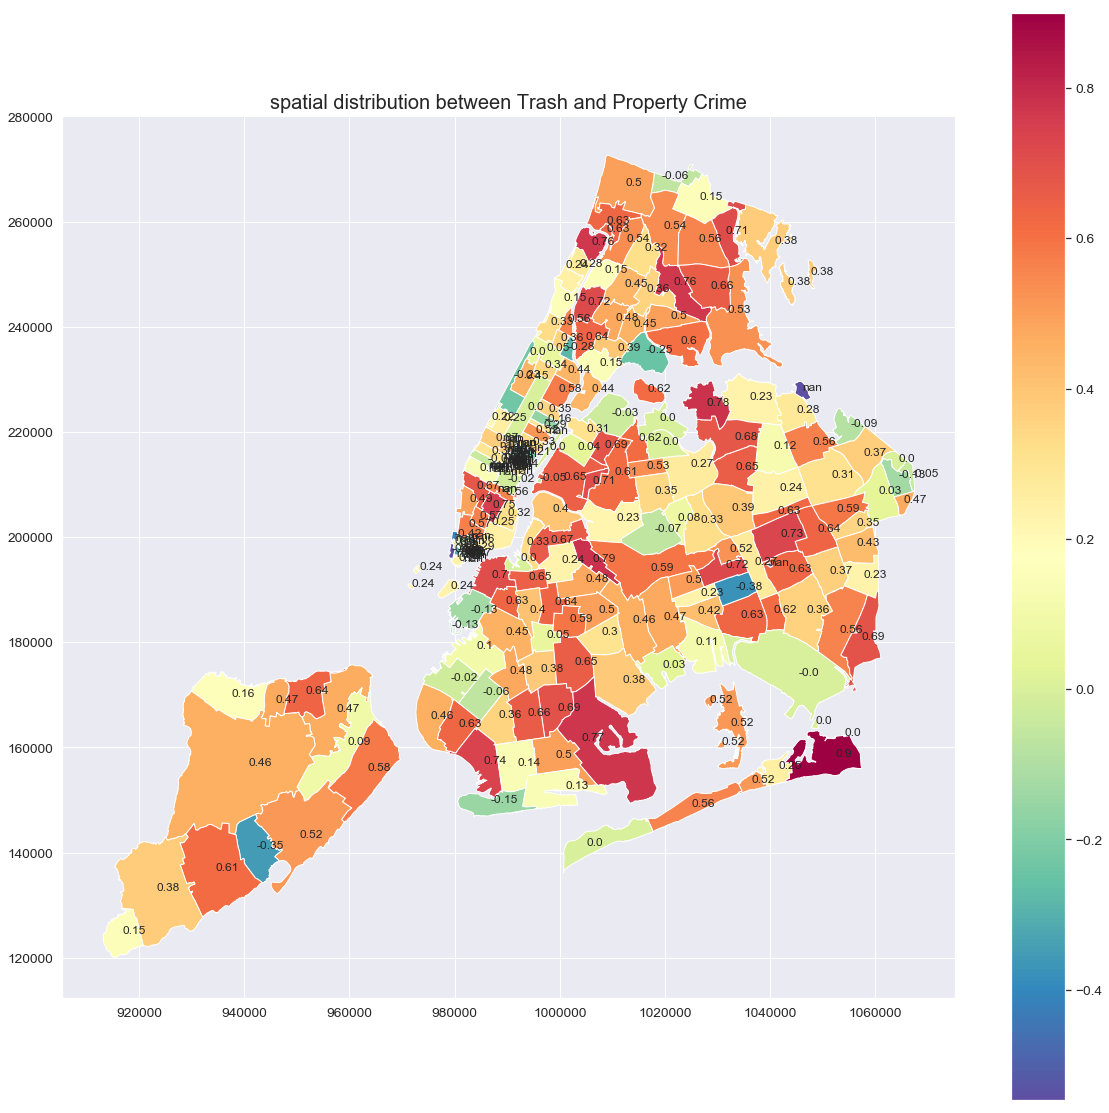

In [123]:
# index_ = zipcode_disorder_crime_corr_pd_geo["trash_Property"].values
# zipcode_disorder_crime_corr_pd_geo["trash_Property_percentile"] = zipcode_disorder_crime_corr_pd_geo["trash_Property"].apply(lambda x:stats.percentileofscore(index_, x)) 

zipcode_disorder_crime_corr_pd_geo.plot(column='trash_Property',colormap='Spectral_r',legend=True,markersize=0.01,figsize=(20,20))

zipcode_disorder_crime_corr_pd_geo['coords'] = zipcode_disorder_crime_corr_pd_geo['geometry'].apply(lambda x: x.representative_point().coords[0])
for n, i in enumerate(zipcode_disorder_crime_corr_pd_geo['coords']):
    plt.text(i[0]-0.2, i[1], round(zipcode_disorder_crime_corr_pd_geo['trash_Property'][n], 2), fontsize=12, horizontalalignment="left")  # 标注位置X，Y，标注内容
    
plt.title("spatial distribution between Trash and Property Crime",fontsize=20 )    

##  Uncivil Use of Space & Property Crime

Text(0.5, 1.0, 'spatial distribution between Uncivil Use of Space and Property Crime')

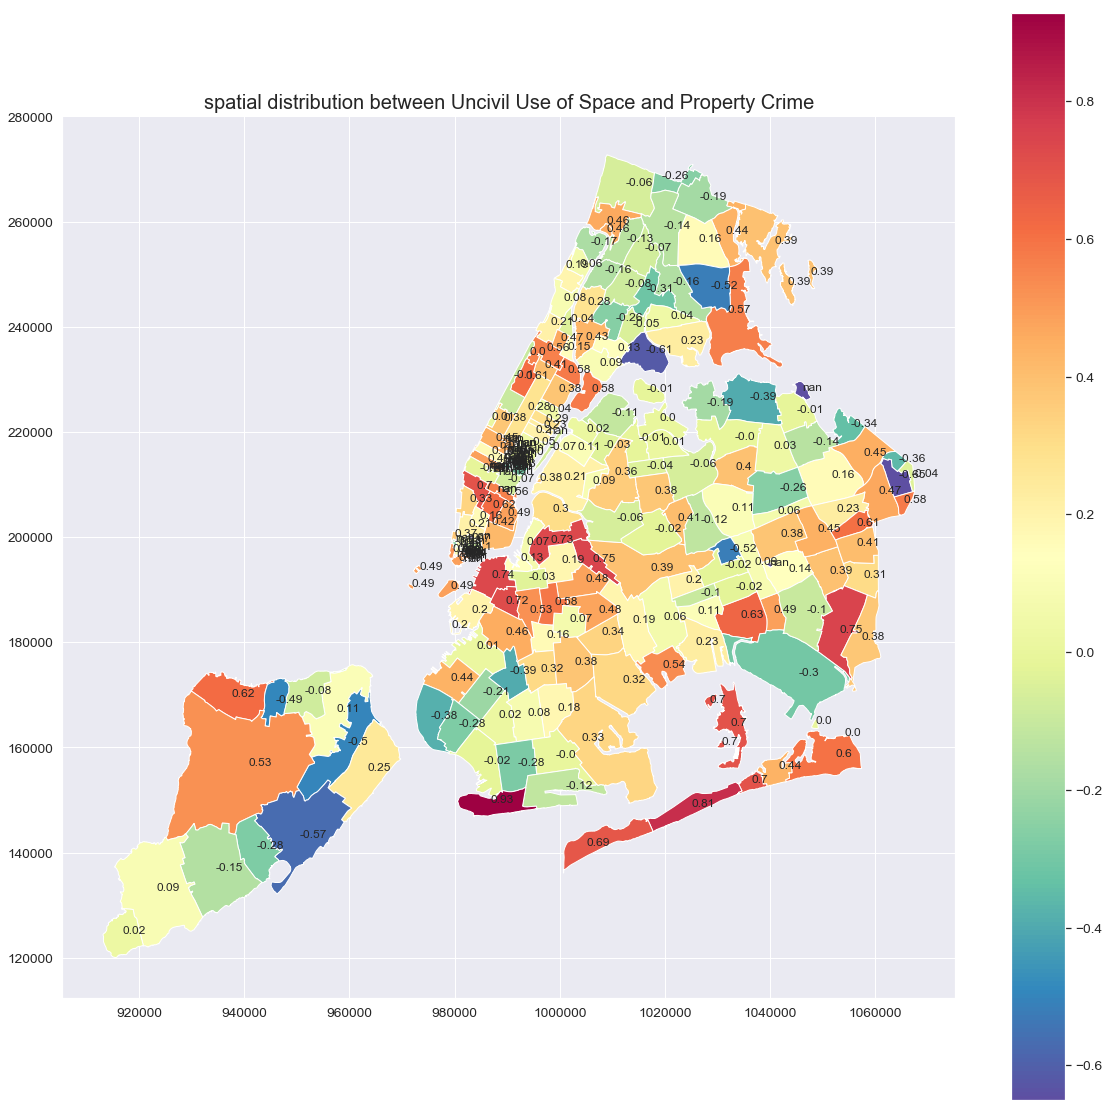

In [124]:
# index_ = zipcode_disorder_crime_corr_pd_geo["Uncivil_Property"].values
# zipcode_disorder_crime_corr_pd_geo["Uncivil_Property_percentile"] = zipcode_disorder_crime_corr_pd_geo["Uncivil_Property"].apply(lambda x:stats.percentileofscore(index_, x)) 

zipcode_disorder_crime_corr_pd_geo.plot(column='Uncivil_Property',colormap='Spectral_r',legend=True,markersize=0.01,figsize=(20,20))
for n, i in enumerate(zipcode_disorder_crime_corr_pd_geo['coords']):
    plt.text(i[0], i[1], round(zipcode_disorder_crime_corr_pd_geo['Uncivil_Property'][n], 2), fontsize=12, horizontalalignment="left")  # 标注位置X，Y，标注内容
    
    
plt.title("spatial distribution between Uncivil Use of Space and Property Crime",fontsize=20 )  

## 研究 纽约市 trash 与 Violent Crime在不同区域内的相关性的分布

Text(0.5, 1.0, 'spatial distribution between Trash and Violent Crime')

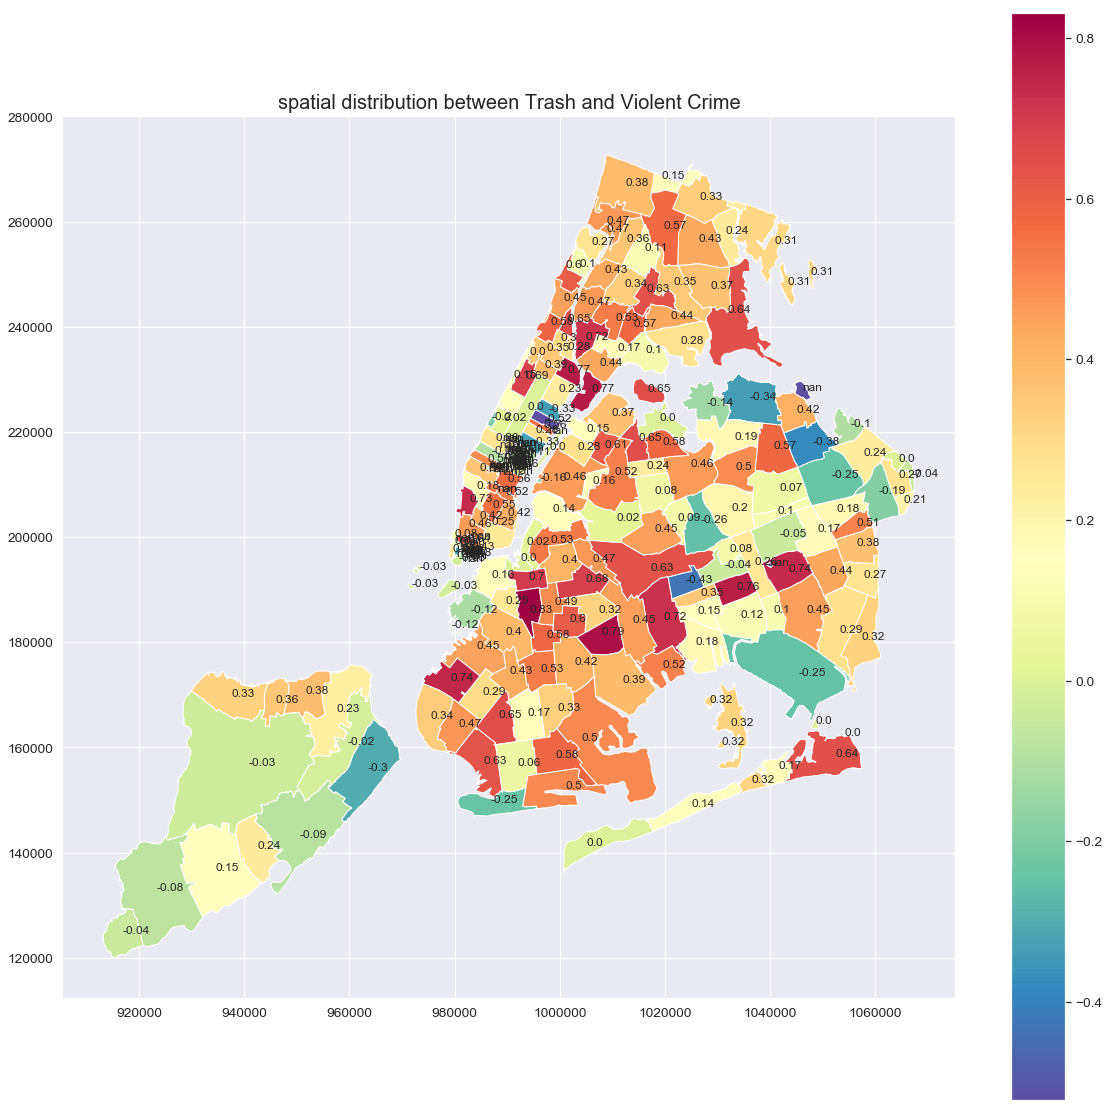

In [125]:
# index_ = zipcode_disorder_crime_corr_pd_geo["trash_Violent"].values
# zipcode_disorder_crime_corr_pd_geo["trash_Violent_percentile"] = zipcode_disorder_crime_corr_pd_geo["trash_Violent"].apply(lambda x:stats.percentileofscore(index_, x)) 

zipcode_disorder_crime_corr_pd_geo.plot(column='trash_Violent',colormap='Spectral_r',legend=True,markersize=0.01,figsize=(20,20))

for n, i in enumerate(zipcode_disorder_crime_corr_pd_geo['coords']):
    plt.text(i[0], i[1], round(zipcode_disorder_crime_corr_pd_geo['trash_Violent'][n], 2), fontsize=12, horizontalalignment="left")  # 标注位置X，Y，标注内容
    
    
plt.title("spatial distribution between Trash and Violent Crime",fontsize=20 ) 

##  Uncivil Use of Space & Violent Crime

Text(0.5, 1.0, 'spatial distribution between Uncivil Use of Space and Violent Crime')

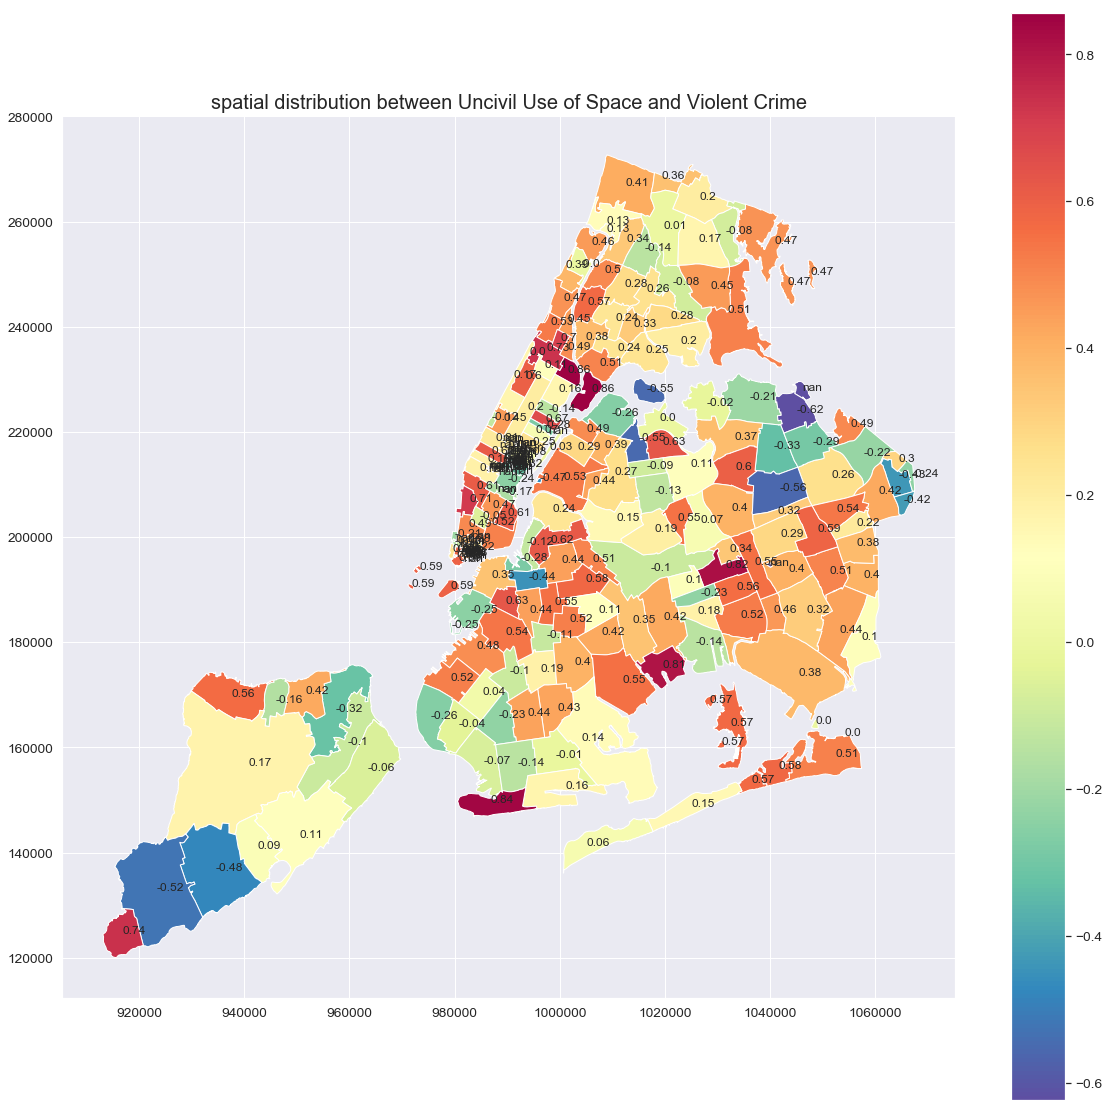

In [126]:
# index_ = zipcode_disorder_crime_corr_pd_geo["Uncivil_Violent"].values
# zipcode_disorder_crime_corr_pd_geo["Uncivil_Violent_percentile"] = zipcode_disorder_crime_corr_pd_geo["Uncivil_Violent"].apply(lambda x:stats.percentileofscore(index_, x)) 

zipcode_disorder_crime_corr_pd_geo.plot(column='Uncivil_Violent',colormap='Spectral_r',legend=True,markersize=0.01,figsize=(20,20))

for n, i in enumerate(zipcode_disorder_crime_corr_pd_geo['coords']):
    plt.text(i[0], i[1], round(zipcode_disorder_crime_corr_pd_geo['Uncivil_Violent'][n], 2), fontsize=12, horizontalalignment="left")  # 标注位置X，Y，标注内容
    
plt.title("spatial distribution between Uncivil Use of Space and Violent Crime",fontsize=20 ) 

## load income age education dataset

## load houseprice

In [127]:
# zipcode_houseprice.csv
# zipcode_age_edu_income.csv

In [128]:
zipcode_age_edu_income = pd.read_csv("zipcode_age_edu_income.csv")
zipcode_age_edu_income.head()

zipcode   age_perc   edu_perc  income_perc
0  11211.0  91.509434  66.037736    50.943396
1  11216.0  87.264151  71.226415    42.924528
2  11237.0  86.792453  43.867925    37.264151
3  10027.0  75.000000  79.245283    34.433962
4  11105.0  91.037736  78.301887    58.490566

In [129]:
zipcode_houseprice = pd.read_csv("zipcode_houseprice.csv")
zipcode_houseprice.head()

zipcode  house_perc
0  10001.0   88.484848
1  10002.0   95.757576
2  10003.0    9.696970
3  10009.0   13.939394
4  10011.0   24.848485

In [130]:
zipcode_dataset = zipcode_age_edu_income.merge(zipcode_houseprice, on="zipcode")
zipcode_dataset.head()

zipcode   age_perc   edu_perc  income_perc  house_perc
0  11211.0  91.509434  66.037736    50.943396   30.909091
1  11216.0  87.264151  71.226415    42.924528    3.030303
2  11237.0  86.792453  43.867925    37.264151   45.454545
3  10027.0  75.000000  79.245283    34.433962   71.515152
4  11105.0  91.037736  78.301887    58.490566   98.787879

In [131]:
zipcode_dataset.dtypes

zipcode        float64
age_perc       float64
edu_perc       float64
income_perc    float64
house_perc     float64
dtype: object

In [132]:
zipcode_disorder_count["flag"] = zipcode_disorder_count["zipcode"].apply(lambda x:1 if "-" not in str(x) else 0)
zipcode_disorder_count = zipcode_disorder_count[zipcode_disorder_count.flag==1][["zipcode", "count"]]
zipcode_disorder_count["zipcode"] = zipcode_disorder_count["zipcode"].astype(np.float64)
zipcode_disorder_count.rename(columns={"count":"disorderCount"}, inplace=True)
zipcode_disorder_count.head()

zipcode  disorderCount
0      0.0              1
1      1.0              1
2     11.0              1
3     83.0           2394
4   1422.0              1

In [133]:
zipcode_crime_count.rename(columns={"count":"crimeCount"}, inplace=True)
zipcode_crime_count.head()

zipcode  crimeCount
0     83.0         952
1  10001.0        8138
2  10002.0        7193
3  10003.0        6816
4  10004.0         674

In [134]:
zipcode_info_disorder_crime = zipcode_disorder_count.merge(zipcode_crime_count,on='zipcode',how='inner').merge(zipcode_dataset,on='zipcode',how='inner')
zipcode_info_disorder_crime.head()

zipcode  disorderCount  crimeCount   age_perc   edu_perc  income_perc  \
0  10001.0          42618        8138  83.490566  85.377358    82.075472   
1  10001.0            307        8138  83.490566  85.377358    82.075472   
2  10002.0          64792        7193  70.283019  55.660377    25.000000   
3  10002.0            734        7193  70.283019  55.660377    25.000000   
4  10003.0          49750        6816  88.207547  91.981132    88.207547   

   house_perc  
0   88.484848  
1   88.484848  
2   95.757576  
3   95.757576  
4    9.696970

In [135]:
index_ = zipcode_info_disorder_crime["disorderCount"].values
zipcode_info_disorder_crime["disorderCount_prec"] = zipcode_info_disorder_crime["disorderCount"].apply(lambda x:stats.percentileofscore(index_, x)) 

In [136]:
index_ = zipcode_info_disorder_crime["crimeCount"].values
zipcode_info_disorder_crime["crimeCount_prec"] = zipcode_info_disorder_crime["crimeCount"].apply(lambda x:stats.percentileofscore(index_, x)) 

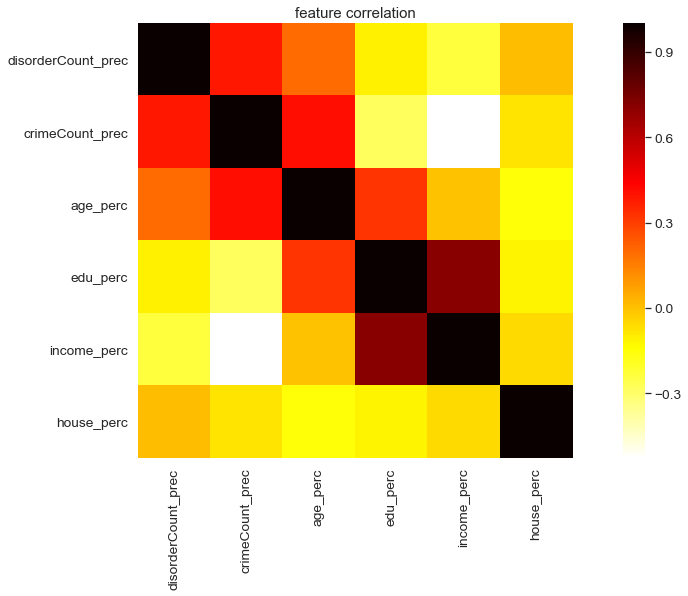

In [137]:
mat_corr = zipcode_info_disorder_crime[[ 'disorderCount_prec', 'crimeCount_prec', 'age_perc', 'edu_perc','income_perc', 'house_perc']].corr()
f, ax = plt.subplots(figsize=(18, 8))
sns.heatmap(mat_corr, cmap="hot_r", square=True)
plt.title("feature correlation")
plt.show()

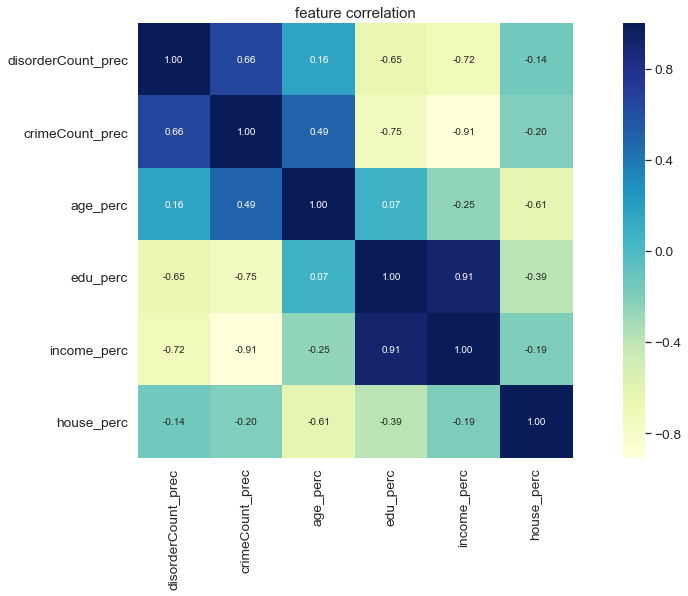

In [138]:
cols = mat_corr.columns
cm = np.corrcoef(mat_corr.values.T)
sns.set(font_scale=1.25)
f, ax = plt.subplots(figsize=(18, 8))
hm = sns.heatmap(cm, cbar=True, annot=True, cmap="YlGnBu",
                 square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols, xticklabels=cols)

plt.title("feature correlation")
plt.show()

In [139]:
zipcode_year_disorder_crime_group = zipcode_year_month_disorder_crime_pd.groupby(["zipcode"])['Damage', 'Drug & Alcohol', 'Graffiti',
       'Misdemeanor & Violation', 'Noise', 'Others', 'Trash',
       'Uncivil Use of Space', 'Property Crime', 'Violent Crime']

zipcode_month_disorder_crime_count = []
for key, values in zipcode_year_disorder_crime_group:
    zipcode = key
    _count = list(np.sum(values[['Damage', 'Drug & Alcohol', 'Graffiti','Misdemeanor & Violation', 'Noise', 'Others', 'Trash', 'Uncivil Use of Space', 'Property Crime', 'Violent Crime']]).values)
    zipcode_month_count = [zipcode] + _count
    zipcode_month_disorder_crime_count.append(zipcode_month_count)
    
zipcode_month_disorder_crime_count = np.array(zipcode_month_disorder_crime_count)
    
zipcode_year_month_disorder_crime_average_pd = pd.DataFrame()
zipcode_year_month_disorder_crime_average_pd["zipcode"] = zipcode_month_disorder_crime_count[:,0]

zipcode_year_month_disorder_crime_average_pd["Damage"] = zipcode_month_disorder_crime_count[:,1]
zipcode_year_month_disorder_crime_average_pd["Drug & Alcohol"] = zipcode_month_disorder_crime_count[:,2]
zipcode_year_month_disorder_crime_average_pd["Graffiti"] = zipcode_month_disorder_crime_count[:,3]
zipcode_year_month_disorder_crime_average_pd["Misdemeanor & Violation"] = zipcode_month_disorder_crime_count[:,4]
zipcode_year_month_disorder_crime_average_pd["Noise"] = zipcode_month_disorder_crime_count[:,5]
zipcode_year_month_disorder_crime_average_pd["Others"] = zipcode_month_disorder_crime_count[:,6]
zipcode_year_month_disorder_crime_average_pd["Trash"] = zipcode_month_disorder_crime_count[:,7]
zipcode_year_month_disorder_crime_average_pd["Uncivil Use of Space"] = zipcode_month_disorder_crime_count[:,8]
zipcode_year_month_disorder_crime_average_pd["Property Crime"] = zipcode_month_disorder_crime_count[:,9]
zipcode_year_month_disorder_crime_average_pd["Violent Crime"] = zipcode_month_disorder_crime_count[:,10]
    


In [140]:
zipcode_year_month_disorder_crime_average_pd.head()

zipcode  Damage  Drug & Alcohol  Graffiti  Misdemeanor & Violation  \
0     83.0    12.0             0.0       0.0                   2171.0   
1  10001.0  3829.0           341.0     510.0                  19837.0   
2  10002.0  5975.0           399.0    3445.0                  19762.0   
3  10003.0  5527.0           302.0    1021.0                  15404.0   
4  10004.0  1373.0            41.0      12.0                   2344.0   

     Noise  Others  Trash  Uncivil Use of Space  Property Crime  Violent Crime  
0    159.0    26.0    0.0                  27.0           734.0          239.0  
1   8934.0  5985.0   11.0                3478.0          7471.0          956.0  
2  27025.0  1718.0   18.0                7184.0          5448.0         2004.0  
3  17246.0  6917.0   20.0                3907.0          6012.0         1076.0  
4    850.0   612.0    3.0                1127.0           608.0          105.0

In [141]:
for i in ['Damage', 'Drug & Alcohol', 'Graffiti', 'Misdemeanor & Violation', 'Noise', 'Others', 'Trash','Uncivil Use of Space', 'Property Crime', 'Violent Crime']:
    index_ = zipcode_year_month_disorder_crime_average_pd[i].values
    zipcode_year_month_disorder_crime_average_pd[i + "_perc"] = zipcode_year_month_disorder_crime_average_pd[i].apply(lambda x:stats.percentileofscore(index_, x)) 

In [142]:
zipcode_infos = zipcode_year_month_disorder_crime_average_pd.merge(zipcode_dataset,on='zipcode',how='inner')
zipcode_infos.head()

zipcode  Damage  Drug & Alcohol  Graffiti  Misdemeanor & Violation  \
0  10001.0  3829.0           341.0     510.0                  19837.0   
1  10002.0  5975.0           399.0    3445.0                  19762.0   
2  10003.0  5527.0           302.0    1021.0                  15404.0   
3  10009.0  3362.0           258.0    1184.0                  10510.0   
4  10011.0  5269.0           289.0     573.0                  13968.0   

     Noise  Others  Trash  Uncivil Use of Space  Property Crime  ...  \
0   8934.0  5985.0   11.0                3478.0          7471.0  ...   
1  27025.0  1718.0   18.0                7184.0          5448.0  ...   
2  17246.0  6917.0   20.0                3907.0          6012.0  ...   
3  24638.0  2051.0   15.0                3200.0          3580.0  ...   
4  11514.0  5048.0   13.0                3604.0          5858.0  ...   

   Noise_perc  Others_perc  Trash_perc  Uncivil Use of Space_perc  \
0   56.020942    98.429319   17.277487                  35.078534   
1   92.146597    89.005236   22.774869                  59.685864   
2   81.675393    99.476440   24.607330                  41.361257   
3   89.005236    91.099476   20.942408                  32.460733   
4   71.204188    97.382199   19.633508                  37.172775   

   Property Crime_perc  Violent Crime_perc   age_perc   edu_perc  income_perc  \
0           100.000000           61.780105  83.490566  85.377358    82.075472   
1            93.717277           84.816754  70.283019  55.660377    25.000000   
2            98.429319           69.633508  88.207547  91.981132    88.207547   
3            81.151832           59.685864  87.735849  77.830189    39.622642   
4            97.382199           71.204188  89.150943  89.622642    89.622642   

   house_perc  
0   88.484848  
1   95.757576  
2    9.696970  
3   13.939394  
4   24.848485  

[5 rows x 25 columns]

In [143]:
needCols = [i for i in zipcode_infos.columns if "perc" in i]
needCols

['Damage_perc',
 'Drug & Alcohol_perc',
 'Graffiti_perc',
 'Misdemeanor & Violation_perc',
 'Noise_perc',
 'Others_perc',
 'Trash_perc',
 'Uncivil Use of Space_perc',
 'Property Crime_perc',
 'Violent Crime_perc',
 'age_perc',
 'edu_perc',
 'income_perc',
 'house_perc']

In [144]:
zipcode_needInfos = zipcode_infos[needCols]
zipcode_needInfos.head()

Damage_perc  Drug & Alcohol_perc  Graffiti_perc  \
0    47.643979            92.670157      66.753927   
1    77.486911            97.382199     100.000000   
2    70.680628            85.602094      91.099476   
3    37.696335            79.319372      94.240838   
4    66.492147            84.554974      70.157068   

   Misdemeanor & Violation_perc  Noise_perc  Others_perc  Trash_perc  \
0                     92.670157   56.020942    98.429319   17.277487   
1                     92.146597   92.146597    89.005236   22.774869   
2                     83.246073   81.675393    99.476440   24.607330   
3                     67.015707   89.005236    91.099476   20.942408   
4                     80.104712   71.204188    97.382199   19.633508   

   Uncivil Use of Space_perc  Property Crime_perc  Violent Crime_perc  \
0                  35.078534           100.000000           61.780105   
1                  59.685864            93.717277           84.816754   
2                  41.361257            98.429319           69.633508   
3                  32.460733            81.151832           59.685864   
4                  37.172775            97.382199           71.204188   

    age_perc   edu_perc  income_perc  house_perc  
0  83.490566  85.377358    82.075472   88.484848  
1  70.283019  55.660377    25.000000   95.757576  
2  88.207547  91.981132    88.207547    9.696970  
3  87.735849  77.830189    39.622642   13.939394  
4  89.150943  89.622642    89.622642   24.848485

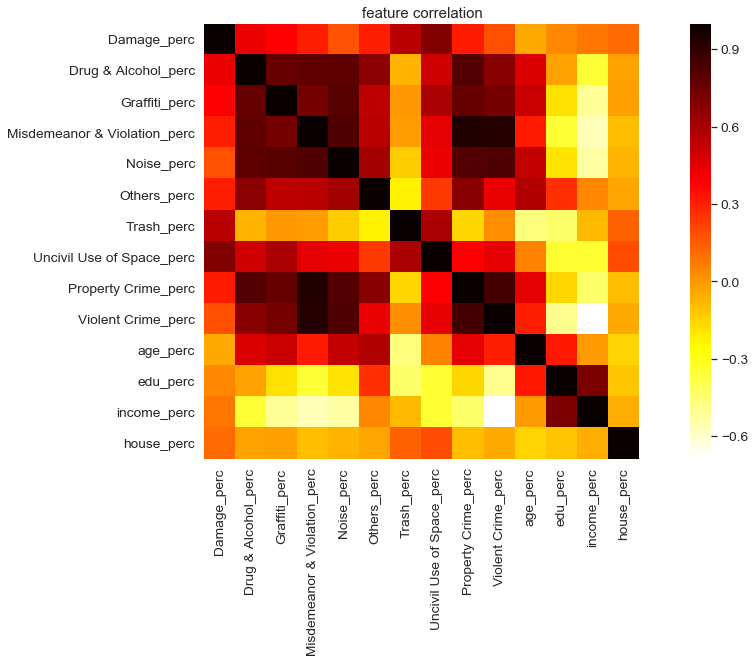

In [145]:
mat_corr = zipcode_needInfos.corr()
f, ax = plt.subplots(figsize=(18, 8))
sns.heatmap(mat_corr, cmap="hot_r", square=True)
plt.title("feature correlation")
plt.show()

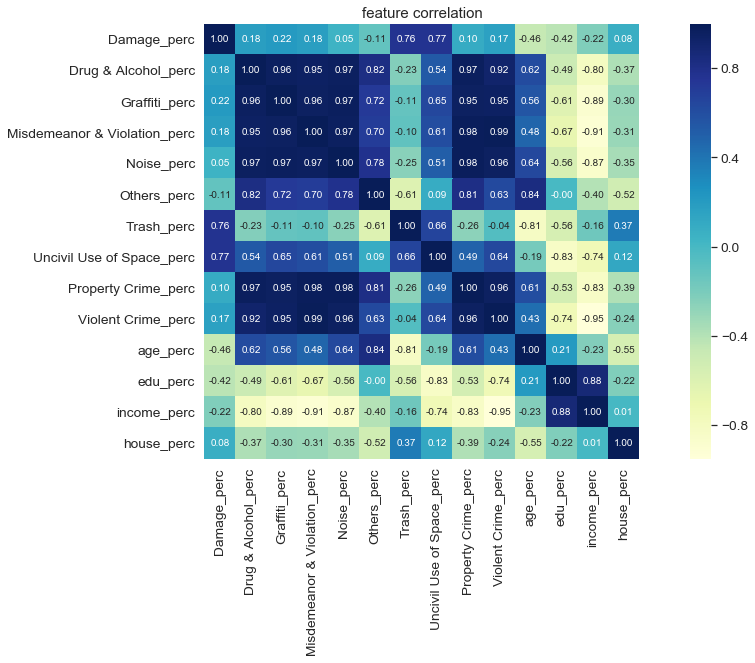

In [146]:
cols = mat_corr.columns
cm = np.corrcoef(mat_corr.values.T)
sns.set(font_scale=1.25)
f, ax = plt.subplots(figsize=(18, 8))
hm = sns.heatmap(cm, cbar=True, annot=True, cmap="YlGnBu",
                 square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols, xticklabels=cols)

plt.title("feature correlation")
plt.show()

## police dataset

In [147]:
# read data

In [148]:
sqf2015 = pd.read_csv("../Data/sqf data/sqf-2015.csv")[['xcoord', 'ycoord']]
sqf2016 = pd.read_csv("../Data/sqf data/sqf-2016.csv")[['xcoord', 'ycoord']]
sqf2017 = pd.read_excel("../Data/sqf data/sqf-2017.xlsx")[['STOP_LOCATION_X', 'STOP_LOCATION_Y']]
sqf2018 = pd.read_excel("../Data/sqf data/sqf-2018.xlsx")[['STOP_LOCATION_X', 'STOP_LOCATION_Y']]
sqf2019 = pd.read_excel("../Data/sqf data/sqf-2019.xlsx")[['STOP_LOCATION_X', 'STOP_LOCATION_Y']]

In [149]:
sqf2017.rename(columns={"STOP_LOCATION_X":"xcoord"}, inplace=True)
sqf2017.rename(columns={"STOP_LOCATION_Y":"ycoord"}, inplace=True)

sqf2018.rename(columns={"STOP_LOCATION_X":"xcoord"}, inplace=True)
sqf2018.rename(columns={"STOP_LOCATION_Y":"ycoord"}, inplace=True)

sqf2019.rename(columns={"STOP_LOCATION_X":"xcoord"}, inplace=True)
sqf2019.rename(columns={"STOP_LOCATION_Y":"ycoord"}, inplace=True)

In [150]:
sqf = sqf2015.append([sqf2016, sqf2017, sqf2018, sqf2019])

In [151]:
sqf

xcoord   ycoord
0      1000091   156314
1       994617   227693
2       991510   225019
3       991510   225019
4       991510   225019
5       991510   225019
6      1005554   179416
7       990820   200020
8       987521   201066
9       974057   164979
10      998617   171801
11     1017302   182366
12      986819   214690
13      938092   169830
14     1001575   232339
15     1002134   229289
16      985764   213806
17     1009502   218368
18     1002001   246760
19     1000489   237510
20     1000029   192060
21      986286   173740
22      986286   173740
23      986286   173740
24     1010701   217852
25     1010701   217852
26      998966   164071
27     1032091   189164
28     1009105   235656
29      987720   216313
...        ...      ...
13429   985969   158583
13430   985969   158583
13431   985969   158583
13432   985969   158583
13433  1001789   168998
13434  1004620   178604
13435  1004620   178604
13436  1004620   178604
13437  1004620   178604
13438  1004620   178604
13439  1009450   178286
13440  1011710   179129
13441  1014797   183741
13442  1015671   184579
13443  1000423   185111
13444   995703   193512
13445   989387   190637
13446   989387   190637
13447   989387   190637
13448   989387   190637
13449   989387   190637
13450  1041349   156139
13451  1041349   156139
13452  1041349   156139
13453  1044257   198235
13454  1037778   194006
13455  1033722   205506
13456  1026950   225017
13457  1030630   213662
13458  1042383   189913

[71064 rows x 2 columns]

In [152]:
#load the resulting shapefile using geopandas 
zipcode = gpd.read_file('../Data/ZIPCODE/ZIP_CODE_040114.shp')
zipcode.head()

zipcode_polygon = zipcode[["ZIPCODE", "geometry"]].values
def getZipcode(p):
    for code, geometry in zipcode_polygon:
        if geometry.contains(p):
            return str(int(code))

In [153]:
zipcode_list = []
for idx, row in tqdm(sqf.iterrows()):
    X_COORD_CD, Y_COORD_CD = row
    try:
        code = getZipcode(Point(float(X_COORD_CD), float(Y_COORD_CD)))
        zipcode_list.append(code)
    except:
        zipcode_list.append(-1)

71064it [04:12, 280.94it/s]


In [154]:
sqf["zipcode"] = zipcode_list

In [155]:
zipcode.dtypes

ZIPCODE         object
BLDGZIP         object
PO_NAME         object
POPULATION     float64
AREA           float64
STATE           object
COUNTY          object
ST_FIPS         object
CTY_FIPS        object
URL             object
SHAPE_AREA     float64
SHAPE_LEN      float64
geometry      geometry
dtype: object

In [156]:
sqf["zipcode"] = sqf["zipcode"].astype(object)
sqf.head()

xcoord   ycoord zipcode
0  1000091   156314   11229
1   994617   227693      83
2   991510   225019   10024
3   991510   225019   10024
4   991510   225019   10024

In [157]:
sqf.dtypes

xcoord     object
ycoord     object
zipcode    object
dtype: object

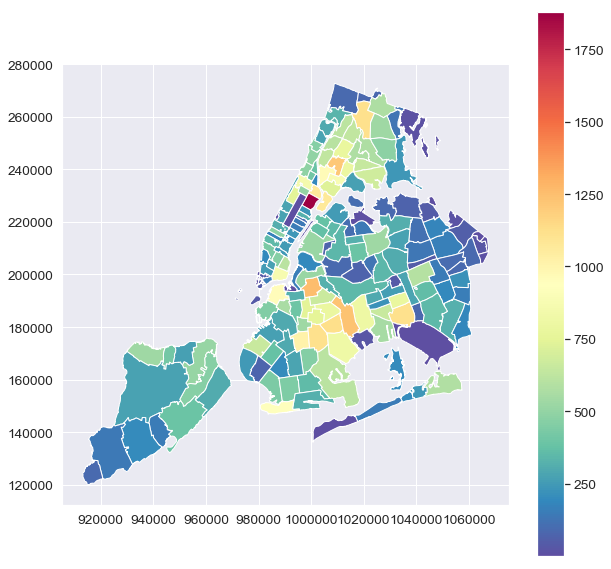

In [158]:
zipcode_sqf_count = sqf.groupby("zipcode").zipcode.agg('count').to_frame('sqf_count').reset_index()
zipcode_sqf_count_geo = zipcode.merge(zipcode_sqf_count,left_on='ZIPCODE',right_on='zipcode',how='left')
zipcode_sqf_count_geo.plot(column='sqf_count',colormap='Spectral_r',legend=True,markersize=0.01,figsize=(10,10))

In [159]:
zipcode_sqf_count["zipcode"] = zipcode_sqf_count["zipcode"].astype(float)
zipcode_sqf_count

zipcode  sqf_count
0       -1.0       1168
1    10001.0        349
2    10002.0        873
3    10003.0        466
4    10004.0         43
5    10005.0         20
6    10006.0         26
7    10007.0         39
8    10009.0        612
9    10010.0        246
10   10011.0        435
11   10012.0        266
12   10013.0        251
13   10014.0        196
14   10016.0        256
15   10017.0        203
16   10018.0        176
17   10019.0        312
18   10020.0          8
19   10021.0        147
20   10022.0        237
21   10023.0        275
22   10024.0        286
23   10025.0        743
24   10026.0        506
25   10027.0        854
26   10028.0        317
27   10029.0       1878
28   10030.0        408
29   10031.0        489
..       ...        ...
157  11379.0         73
158  11385.0        352
159  11411.0        161
160  11412.0        197
161  11413.0        319
162  11414.0        557
163  11415.0         42
164  11416.0        224
165  11417.0        655
166  11418.0        262
167  11419.0        779
168  11420.0       1122
169  11421.0        296
170  11422.0        191
171  11423.0        154
172  11426.0         92
173  11427.0        102
174  11428.0         92
175  11429.0        226
176  11430.0          2
177  11432.0        599
178  11433.0        363
179  11434.0        350
180  11435.0        284
181  11436.0         83
182  11691.0        585
183  11692.0        237
184  11693.0        201
185  11694.0        149
186     83.0        224

[187 rows x 2 columns]

In [160]:
zipcode_infos_sqf = zipcode_infos.merge(zipcode_sqf_count,on='zipcode',how='left')
zipcode_infos_sqf.head()

zipcode  Damage  Drug & Alcohol  Graffiti  Misdemeanor & Violation  \
0  10001.0  3829.0           341.0     510.0                  19837.0   
1  10002.0  5975.0           399.0    3445.0                  19762.0   
2  10003.0  5527.0           302.0    1021.0                  15404.0   
3  10009.0  3362.0           258.0    1184.0                  10510.0   
4  10011.0  5269.0           289.0     573.0                  13968.0   

     Noise  Others  Trash  Uncivil Use of Space  Property Crime  ...  \
0   8934.0  5985.0   11.0                3478.0          7471.0  ...   
1  27025.0  1718.0   18.0                7184.0          5448.0  ...   
2  17246.0  6917.0   20.0                3907.0          6012.0  ...   
3  24638.0  2051.0   15.0                3200.0          3580.0  ...   
4  11514.0  5048.0   13.0                3604.0          5858.0  ...   

   Others_perc  Trash_perc  Uncivil Use of Space_perc  Property Crime_perc  \
0    98.429319   17.277487                  35.078534           100.000000   
1    89.005236   22.774869                  59.685864            93.717277   
2    99.476440   24.607330                  41.361257            98.429319   
3    91.099476   20.942408                  32.460733            81.151832   
4    97.382199   19.633508                  37.172775            97.382199   

   Violent Crime_perc   age_perc   edu_perc  income_perc  house_perc  \
0           61.780105  83.490566  85.377358    82.075472   88.484848   
1           84.816754  70.283019  55.660377    25.000000   95.757576   
2           69.633508  88.207547  91.981132    88.207547    9.696970   
3           59.685864  87.735849  77.830189    39.622642   13.939394   
4           71.204188  89.150943  89.622642    89.622642   24.848485   

   sqf_count  
0        349  
1        873  
2        466  
3        612  
4        435  

[5 rows x 26 columns]

In [161]:
index_ = zipcode_infos_sqf["sqf_count"].values
zipcode_infos_sqf["sqf_count_perc"] = zipcode_infos_sqf["sqf_count"].apply(lambda x:stats.percentileofscore(index_, x)) 
zipcode_infos_sqf.head()

zipcode  Damage  Drug & Alcohol  Graffiti  Misdemeanor & Violation  \
0  10001.0  3829.0           341.0     510.0                  19837.0   
1  10002.0  5975.0           399.0    3445.0                  19762.0   
2  10003.0  5527.0           302.0    1021.0                  15404.0   
3  10009.0  3362.0           258.0    1184.0                  10510.0   
4  10011.0  5269.0           289.0     573.0                  13968.0   

     Noise  Others  Trash  Uncivil Use of Space  Property Crime  ...  \
0   8934.0  5985.0   11.0                3478.0          7471.0  ...   
1  27025.0  1718.0   18.0                7184.0          5448.0  ...   
2  17246.0  6917.0   20.0                3907.0          6012.0  ...   
3  24638.0  2051.0   15.0                3200.0          3580.0  ...   
4  11514.0  5048.0   13.0                3604.0          5858.0  ...   

   Trash_perc  Uncivil Use of Space_perc  Property Crime_perc  \
0   17.277487                  35.078534           100.000000   
1   22.774869                  59.685864            93.717277   
2   24.607330                  41.361257            98.429319   
3   20.942408                  32.460733            81.151832   
4   19.633508                  37.172775            97.382199   

   Violent Crime_perc   age_perc   edu_perc  income_perc  house_perc  \
0           61.780105  83.490566  85.377358    82.075472   88.484848   
1           84.816754  70.283019  55.660377    25.000000   95.757576   
2           69.633508  88.207547  91.981132    88.207547    9.696970   
3           59.685864  87.735849  77.830189    39.622642   13.939394   
4           71.204188  89.150943  89.622642    89.622642   24.848485   

   sqf_count  sqf_count_perc  
0        349       53.395062  
1        873       91.358025  
2        466       64.814815  
3        612       78.395062  
4        435       61.728395  

[5 rows x 27 columns]

In [171]:
needCols = [i for i in zipcode_infos_sqf.columns if "perc" not in i]
needCols

['zipcode',
 'Damage',
 'Drug & Alcohol',
 'Graffiti',
 'Misdemeanor & Violation',
 'Noise',
 'Others',
 'Trash',
 'Uncivil Use of Space',
 'Property Crime',
 'Violent Crime',
 'sqf_count']

In [175]:
needCols = [ 'Damage',
 'Drug & Alcohol',
 'Graffiti',
 'Misdemeanor & Violation',
 'Noise',
 'Others',
 'Trash',
 'Uncivil Use of Space',
 'Property Crime',
 'Violent Crime',
 'sqf_count']

In [176]:
zipcode_sqf_needInfos = zipcode_infos_sqf[needCols]
zipcode_sqf_needInfos.head()

Damage  Drug & Alcohol  Graffiti  Misdemeanor & Violation    Noise  Others  \
0  3829.0           341.0     510.0                  19837.0   8934.0  5985.0   
1  5975.0           399.0    3445.0                  19762.0  27025.0  1718.0   
2  5527.0           302.0    1021.0                  15404.0  17246.0  6917.0   
3  3362.0           258.0    1184.0                  10510.0  24638.0  2051.0   
4  5269.0           289.0     573.0                  13968.0  11514.0  5048.0   

   Trash  Uncivil Use of Space  Property Crime  Violent Crime  sqf_count  
0   11.0                3478.0          7471.0          956.0        349  
1   18.0                7184.0          5448.0         2004.0        873  
2   20.0                3907.0          6012.0         1076.0        466  
3   15.0                3200.0          3580.0          902.0        612  
4   13.0                3604.0          5858.0         1104.0        435

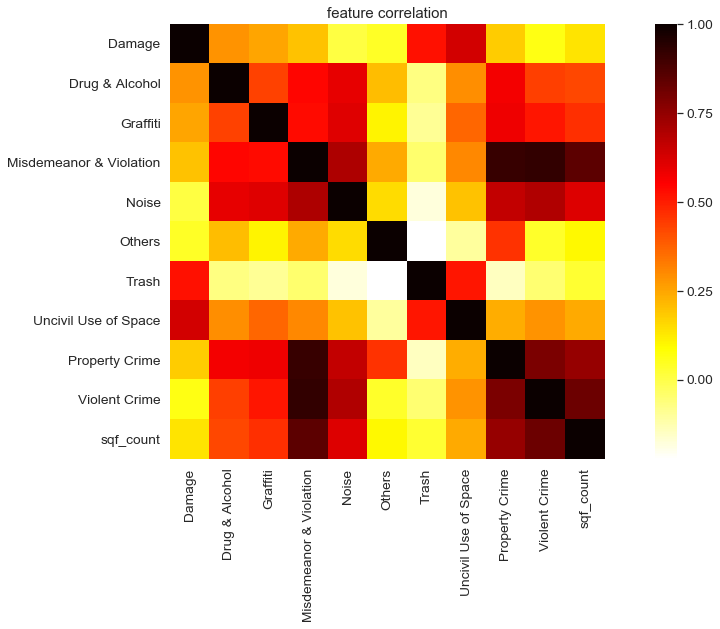

In [177]:
mat_corr = zipcode_sqf_needInfos.corr()
f, ax = plt.subplots(figsize=(18, 8))
sns.heatmap(mat_corr, cmap="hot_r", square=True)
plt.title("feature correlation")
plt.show()

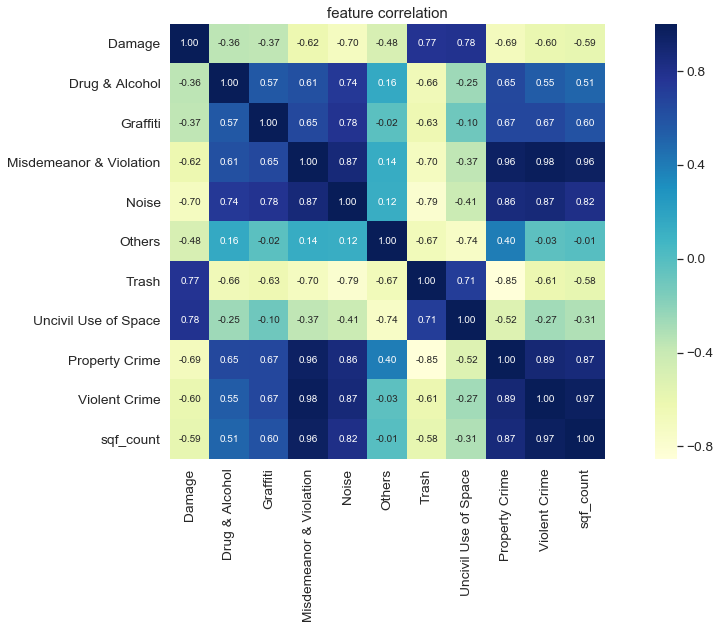

In [178]:
cols = mat_corr.columns
cm = np.corrcoef(mat_corr.values.T)
sns.set(font_scale=1.25)
f, ax = plt.subplots(figsize=(18, 8))
hm = sns.heatmap(cm, cbar=True, annot=True, cmap="YlGnBu",
                 square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols, xticklabels=cols)

plt.title("feature correlation")
plt.show()